**PLAN**

Sommaire

SECTION 1: SEGMENTATION RFM

1.1.EXTRACTION DES DONNÉES RFM

1.2.CRÉATION DES QUANTILES POUR CHAQUE VARIABLE RFM

1.3.DÉFINITION DES INTERVALLES POUR CHAQUE VARIABLE RFM

1.4.APPLICATION DE LA FONCTION DE SEGMENTATION

1.5.CALCUL DE LA VALEUR RFM TOTALE

1.6.CRÉATION DE LA COLONNE RFM LEVEL

1.7.ANALYSE DES SEGMENTS RFM

1.8.VISUALISATION DES SEGMENTS RFM

1.9.ANALYSE DES SEGMENTS RFM

SECTION 2 : CHOIX DE LA METHODE DE MODELISATION

2.1. KMEANS

2.2.DBSCAN

2.3.CLUSTERING HIERARCHIQUE


# SECTION 1: SEGMENTATION RFM

In [1]:
# Importation des bibliothèques nécessaires
%matplotlib inline
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Fonction pour importer les bibliothèques
def import_libraries():
    print("Bibliothèques importées avec succès.")

# Appel de la fonction pour importer les bibliothèques
import_libraries()

Bibliothèques importées avec succès.


In [2]:
# Chargement des données
import pandas as pd
from google.colab import drive

# Fonction pour charger les données
def load_data(file_path):
    # Vérification si le code s'exécute dans Google Colab
    if 'google.colab' in str(get_ipython()):
        # Montage de Google Drive
        drive.mount('/gdrive')
        # Ajustement du chemin du fichier dans l'environnement Google Colab
        file_path = '/gdrive' + file_path

    try:
        # Chargement du fichier CSV dans un DataFrame avec pandas
        data_frame = pd.read_csv(file_path)

        # Affichage du nom du DataFrame chargé
        print("Loaded DataFrame:", file_path.split('/')[-1].split('.')[0])

        # Retourne le DataFrame chargé
        return data_frame
    except FileNotFoundError:
        # Affichage d'une erreur si le fichier n'est pas trouvé
        print(f"Error: File not found at {file_path}")

# Spécification du chemin du fichier CSV
file_path = "/MyDrive/Colab Notebooks/Projet_4/olist-cust-seg.csv"

# Appel de la fonction pour charger les données
data = load_data(file_path)

# Affichage des premières lignes du DataFrame
data.head()

Mounted at /gdrive
Loaded DataFrame: olist-cust-seg


,Unnamed: 0,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,recency,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
0,0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,5,112,...,0,0,0,0,0,0,0,0,1,0
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,5,115,...,0,0,0,0,0,0,0,0,1,0
2,2,0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,3,537,...,0,0,0,0,0,0,1,0,0,0
3,3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,10,321,...,0,0,0,0,0,0,0,0,0,0
4,4,0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,11,288,...,0,0,0,0,0,0,0,0,1,0


In [3]:
data.shape

(93358, 55)

###1.1.EXTRACTION DES DONNÉES RFM






In [4]:
rfm_data = data[['customer_unique_id', 'recency', 'frequency', 'monetary_value']]


### 1.2.CRÉATION DES QUANTILES POUR CHAQUE VARIABLE RFM


In [5]:
quantiles = rfm_data.quantile(q=[0.25, 0.5, 0.75])


<ipython-input-5-ee296d34f919>:1: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



### 1.3.DÉFINITION DES INTERVALLES POUR CHAQUE VARIABLE RFM


In [6]:
def rfm_segment(row):
    r_score = int(row['recency'] <= quantiles.loc[0.25, 'recency']) + \
              int(row['recency'] <= quantiles.loc[0.5, 'recency']) + \
              int(row['recency'] <= quantiles.loc[0.75, 'recency']) + 1

    f_score = int(row['frequency'] >= quantiles.loc[0.75, 'frequency']) + \
              int(row['frequency'] >= quantiles.loc[0.5, 'frequency']) + \
              int(row['frequency'] >= quantiles.loc[0.25, 'frequency']) + 1

    m_score = int(row['monetary_value'] >= quantiles.loc[0.75, 'monetary_value']) + \
              int(row['monetary_value'] >= quantiles.loc[0.5, 'monetary_value']) + \
              int(row['monetary_value'] >= quantiles.loc[0.25, 'monetary_value']) + 1

    return str(r_score) + str(f_score) + str(m_score)

### 1.4.APPLICATION DE LA FONCTION DE SEGMENTATION


In [7]:
rfm_data['RFM_Segment'] = rfm_data.apply(rfm_segment, axis=1)

<ipython-input-7-02b11d00a102>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 1.5.CALCUL DE LA VALEUR RFM TOTALE


In [8]:
rfm_data['RFM_Score'] = rfm_data['recency'] + rfm_data['frequency'] + rfm_data['monetary_value']

<ipython-input-8-dc2eda48ce28>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 1.6.CRÉATION DE LA COLONNE RFM LEVEL

In [9]:
rfm_level = ['Gold', 'Silver', 'Bronze']
rfm_data['RFM_Level'] = pd.qcut(rfm_data['RFM_Score'], q=[0, 1/3, 2/3, 1], labels=rfm_level)

# AFFICHAGE DES RÉSULTATS
rfm_data.head()

<ipython-input-9-f926eeeaa907>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,customer_unique_id,recency,frequency,monetary_value,RFM_Segment,RFM_Score,RFM_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,443,254.90,Gold
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,341,143.19,Gold
2,0000f46a3911fa3c0805444483337064,537,1,86.22,142,624.22,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,241,365.62,Silver
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,244,485.89,Bronze


**Commentaire :**  

La première ligne indique qu'un client avec l'identifiant unique '0000366f3b9a7992bf8c76cfdf3221e2' a effectué son dernier achat il y a 112 jours, a une fréquence d'achat de 1, une valeur monétaire totale de 141.90, appartient au segment RFM 'Gold', a un score RFM de 443

### 1.7.ANALYSE DES SEGMENTS RFM

In [10]:
rfm_summary = rfm_data.groupby('RFM_Segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)

In [11]:
print(rfm_summary)

            recency frequency monetary_value      
               mean      mean           mean count
RFM_Segment                                       
141           455.3       1.0           41.5  6079
142           446.2       1.0           82.4  5997
143           452.2       1.1          140.8  5549
144           452.3       1.3          440.9  5686
241           276.6       1.0           41.7  5651
242           277.1       1.0           82.5  5999
243           277.5       1.1          142.3  5802
244           278.3       1.3          438.3  5748
341           168.3       1.0           41.5  5874
342           166.5       1.0           82.4  5674
343           165.9       1.0          142.6  5976
344           165.9       1.3          432.4  5927
441            56.5       1.0           41.5  5732
442            56.6       1.0           82.6  5673
443            58.3       1.0          141.5  6012
444            58.6       1.3          458.5  5979


**Commentaire :**

Le "Segment 144" semble avoir un recency moyen élevé, une fréquence moyenne plus élevée, et un monetary value moyen élevé, indiquant potentiellement des clients qui ont acheté récemment, fréquemment, et avec des dépenses importantes.

### 1.8.VISUALISATION DES SEGMENTS RFM

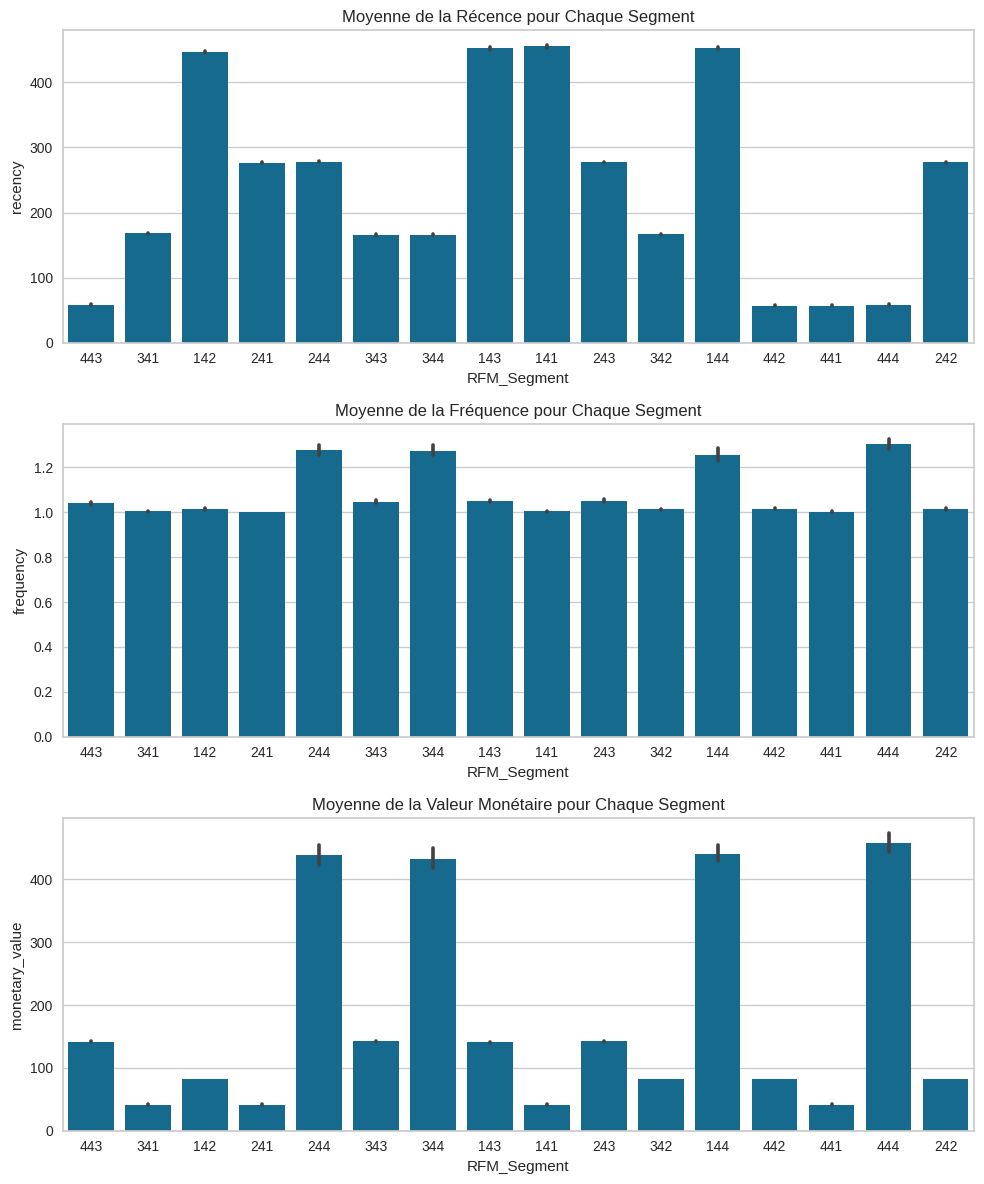

In [12]:
# Création d'une figure avec sous-graphiques
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Visualisation de la moyenne de la récence pour chaque segment
sns.barplot(x='RFM_Segment', y='recency', data=rfm_data, ax=axes[0])
axes[0].set_title('Moyenne de la Récence pour Chaque Segment')

# Visualisation de la moyenne de la fréquence pour chaque segment
sns.barplot(x='RFM_Segment', y='frequency', data=rfm_data, ax=axes[1])
axes[1].set_title('Moyenne de la Fréquence pour Chaque Segment')

# Visualisation de la moyenne de la valeur monétaire pour chaque segment
sns.barplot(x='RFM_Segment', y='monetary_value', data=rfm_data, ax=axes[2])
axes[2].set_title('Moyenne de la Valeur Monétaire pour Chaque Segment')

# Ajustements pour la mise en page
plt.tight_layout()
plt.show()

Interprétation générale :

Les segments RFM 141, 144 et 244 ont des scores RFM élevés, indiquant des clients récemment actifs, fréquents et avec une valeur monétaire significative.
Les valeurs élevées dans les segments suggèrent des clients plus engagés et contribuant davantage à la valeur monétaire totale.

In [13]:
print(rfm_data.columns)


Index(['customer_unique_id', 'recency', 'frequency', 'monetary_value',
       'RFM_Segment', 'RFM_Score', 'RFM_Level'],
      dtype='object')


### 1.9.ANALYSE DES SEGMENTS RFM

In [14]:
# Analyse des segments RFM
segment_analysis = rfm_data.groupby('RFM_Segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': 'mean',
    'customer_unique_id': 'count'
}).reset_index()

segment_analysis.rename(columns={'customer_unique_id': 'CustomerCount'}, inplace=True)

print(segment_analysis)

   RFM_Segment     recency  frequency  monetary_value  CustomerCount
0          141  455.292318   1.003784       41.471829           6079
1          142  446.211439   1.014507       82.386261           5997
2          143  452.187601   1.050460      140.801535           5549
3          144  452.328526   1.255364      440.917411           5686
4          241  276.599363   1.001770       41.662684           5651
5          242  277.086181   1.015669       82.496568           5999
6          243  277.475353   1.052396      142.272358           5802
7          244  278.324809   1.278880      438.289276           5748
8          341  168.257065   1.003916       41.467012           5874
9          342  166.493303   1.013218       82.422009           5674
10         343  165.944779   1.047356      142.575018           5976
11         344  165.888983   1.275013      432.397935           5927
12         441   56.523901   1.002791       41.526621           5732
13         442   56.619778   1.016

**Commentaire :**   

Le nombre de clients dans chaque segment varie, avec le segment RFM 141 ayant le plus grand nombre de clients (6079).

- GRAPHIQUES RADARS (RADAR CHARTS)

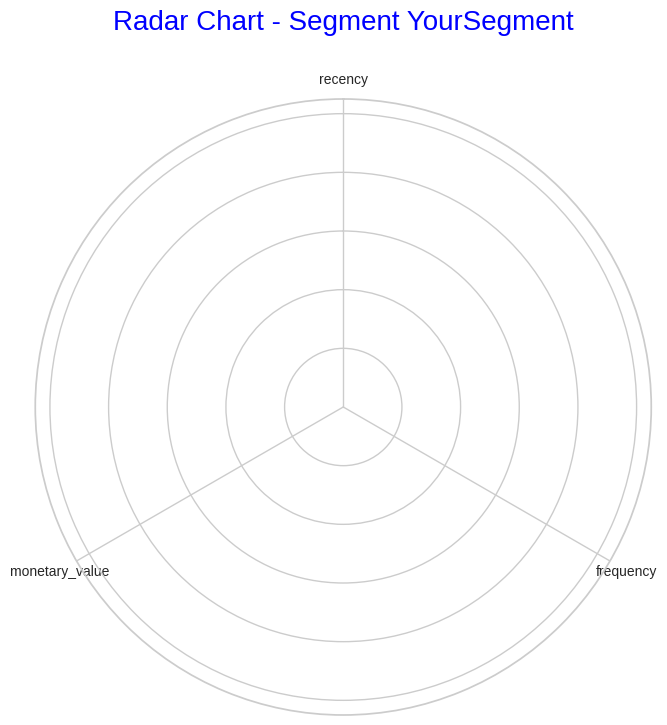

In [15]:
import matplotlib.pyplot as plt
from math import pi

# Graphiques Radars pour les segments RFM
def plot_radar_chart(segment):
    attributes = ['recency', 'frequency', 'monetary_value']
    values = rfm_data.loc[rfm_data['RFM_Segment'] == segment, attributes].mean().values

    # Nombre d'attributs
    num_attributes = len(attributes)

    # Création d'un tableau d'angles équidistants
    angles = [n / float(num_attributes) * 2 * pi for n in range(num_attributes)]
    angles += angles[:1]

    # Initialisation de la figure
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Tracé du radar
    values = list(values) + [values[0]]
    ax.fill(angles, values, color='skyblue', alpha=0.25)
    ax.set_yticklabels([])
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Ajout des labels
    plt.xticks(angles[:-1], attributes)

    plt.title(f'Radar Chart - Segment {segment}', size=20, color='blue', y=1.1)

    plt.show()

plot_radar_chart('YourSegment')

#SECTION 2 : CHOIX DE LA METHODE DE MODELISATION

- Choix des variables autres que RFM pour l'analyse PCA


In [16]:
# Copie du DataFrame pour la modélisation K-means
data_mk = data.copy()

In [17]:
# Installation de la bibliothèque kmodes si elle n'est pas déjà installée
!pip install kmodes

In [18]:
# Sélection des colonnes pertinentes pour la modélisation K-means
data_mk = data_mk[['nb_orders', 'total_spend', 'mean_payment_sequential',
                    'mean_payment_installments', 'mean_review_score', 'mean_delivery_days',
                    'favorite_sale_month', 'recency', 'frequency', 'monetary_value',
                    'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts',
                    'groceries_food_drink', 'health_beauty', 'home_furniture', 'other',
                    'sport', 'technology', 'toys_baby', 'total_items', 'mean_nb_items',
                    'order_total_delay', 'freight_ratio', 'mean_price_order',
                    'customer_city']]

In [19]:
# Suppression de certaines colonnes pour simplifier la modélisation
data_mk.drop(["customer_city", "mean_price_order", "mean_nb_items"], axis=1, inplace=True)

<ipython-input-19-76b66a2a4702>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
# Sélection des caractéristiques catégorielles et numériques
categorical_features = list(data_mk.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
numerical_features = list(data_mk.select_dtypes(include=['int64', 'float64', 'uint8']).columns)

# Affichage des caractéristiques catégorielles et numériques
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: []
Numerical Features: ['nb_orders', 'total_spend', 'mean_payment_sequential', 'mean_payment_installments', 'mean_review_score', 'mean_delivery_days', 'favorite_sale_month', 'recency', 'frequency', 'monetary_value', 'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts', 'groceries_food_drink', 'health_beauty', 'home_furniture', 'other', 'sport', 'technology', 'toys_baby', 'total_items', 'order_total_delay', 'freight_ratio']


In [21]:
data_mk

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,recency,frequency,monetary_value,...,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,order_total_delay,freight_ratio
0,1,141.90,1.0,8.0,5.0,6.0,5,112,1,141.90,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,111,0.08
1,1,27.19,1.0,1.0,4.0,3.0,5,115,1,27.19,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,114,0.30
2,1,86.22,1.0,8.0,3.0,26.0,3,537,1,86.22,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,537,0.20
3,1,43.62,1.0,4.0,4.0,20.0,10,321,1,43.62,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,321,0.40
4,1,196.89,1.0,6.0,5.0,13.0,11,288,1,196.89,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,288,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,1,2067.42,1.0,10.0,5.0,28.0,6,447,2,4134.84,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,447,0.24
93354,1,84.58,1.0,1.0,4.0,30.0,12,262,1,84.58,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,262,0.23
93355,1,112.46,1.0,1.0,5.0,15.0,2,568,1,112.46,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,568,0.20
93356,1,133.69,1.0,5.0,5.0,12.0,5,119,1,133.69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,119,0.14


### 2.1. KMEANS

- Pretraitement des données

In [22]:
# 2.1.1 Normalisation des données RFM
rfm_scaler = MinMaxScaler()
rfm_features = ['recency', 'frequency', 'monetary_value']
data_mk[rfm_features] = rfm_scaler.fit_transform(data_mk[rfm_features])

<ipython-input-22-050372a59071>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
# 2.1.2 Normalisation des autres caractéristiques numériques
other_numerical_features = [col for col in data_mk.columns if col not in rfm_features]
other_scaler = MinMaxScaler()
data_mk[other_numerical_features] = other_scaler.fit_transform(data_mk[other_numerical_features])

<ipython-input-23-d799728eaf41>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
# 2.1.3 Suppression de la colonne 'customer_unique_id'
if "customer_unique_id" in data_mk.columns:
    data_mk = data_mk.drop("customer_unique_id", axis=1)
    print("Column 'customer_unique_id' deleted.")
else:
    print("Column 'customer_unique_id' does not exist in the DataFrame.")

Column 'customer_unique_id' does not exist in the DataFrame.


In [25]:
# Configuration du preprocessor pour les caractéristiques numériques (y compris les variables RFM)
preprocessor_kmeans = ColumnTransformer([
    ('rfm_scaler', rfm_scaler, rfm_features),
    ('other_scaler', other_scaler, other_numerical_features)
])

# Sélection des caractéristiques pour la modélisation K-means
X_kmeans = data_mk.copy()

X_kmeans = pd.DataFrame(X_kmeans, columns=data_mk.columns)

# Prétraitement des données avec MinMaxScaler pour RFM et autres caractéristiques numériques
X_kmeans = preprocessor_kmeans.fit_transform(X_kmeans)

X_kmeans = pd.DataFrame(X_kmeans, columns=data_mk.columns)


-  Recherche du nombre optimal de clusters (k) avec la méthode du coude

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

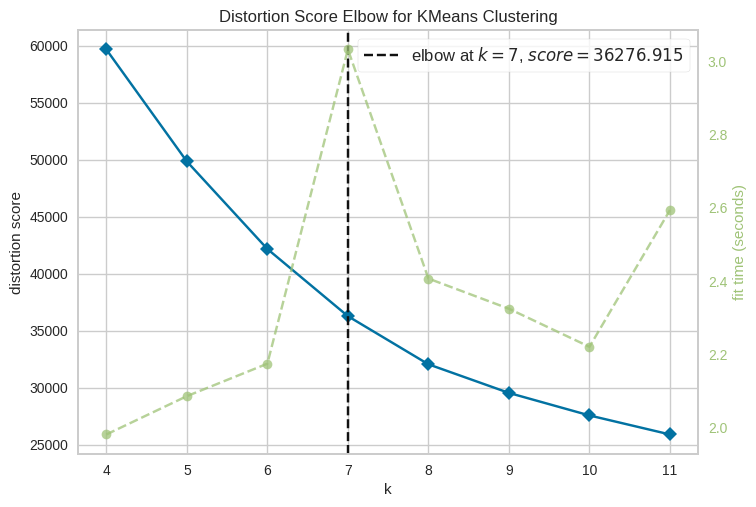

In [27]:
# Récupération du scaler à partir du preprocessor_kmeans
scaler = preprocessor_kmeans.named_transformers_['other_scaler']

# Configuration du visualiseur du coude
kmeans_visualizer = Pipeline([
    ("preprocessor", scaler),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(), k=(4, 12)))
])

# Ajustement du visualiseur aux données
kmeans_visualizer.fit(X_kmeans)

# Affichage du coude pour choisir le nombre optimal de clusters (K)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

# Sélection du meilleur K dans le coude
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

In [28]:
data_mk

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,recency,frequency,monetary_value,...,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,order_total_delay,freight_ratio
0,0.0,0.017497,0.0,0.307692,1.00,0.023923,0.363636,0.155680,0.000000,0.005664,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.155680,0.083333
1,0.0,0.002327,0.0,0.038462,0.75,0.009569,0.363636,0.159888,0.000000,0.001085,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.159888,0.312500
2,0.0,0.010134,0.0,0.307692,0.50,0.119617,0.181818,0.751753,0.000000,0.003442,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.753156,0.208333
3,0.0,0.004500,0.0,0.153846,0.75,0.090909,0.818182,0.448808,0.000000,0.001741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.450210,0.416667
4,0.0,0.024768,0.0,0.230769,1.00,0.057416,0.909091,0.402525,0.000000,0.007859,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.403927,0.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,0.0,0.272126,0.0,0.384615,1.00,0.129187,0.454545,0.625526,0.015873,0.165051,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.013514,0.626928,0.250000
93354,0.0,0.009917,0.0,0.038462,0.75,0.138756,1.000000,0.366059,0.000000,0.003376,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.367461,0.239583
93355,0.0,0.013603,0.0,0.038462,1.00,0.066986,0.090909,0.795231,0.000000,0.004489,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.796634,0.208333
93356,0.0,0.016411,0.0,0.192308,1.00,0.052632,0.363636,0.165498,0.000000,0.005337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.166900,0.145833


In [29]:
# Vérification visuelle du graphique du coude
print(f"Nombre optimal de clusters (K) selon la méthode du coude : {K}")

Nombre optimal de clusters (K) selon la méthode du coude : 7


-  Modélisation k-means

In [30]:
# Configuration du modèle K-means avec le meilleur K dans un pipeline
K = 7  # Remplacez par le meilleur K que vous avez trouvé
kmeans_model = Pipeline([
    ("preprocessor", preprocessor_kmeans),
    ("kmeans", KMeans(n_clusters=K))
])

# Ajustement du modèle aux données
kmeans_model.fit(X_kmeans)

# Obtention des labels des clusters pour chaque client
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_

# Réinitialisation des index du DataFrame après le prétraitement et la transformation PCA
X_kmeans = X_kmeans.reset_index(drop=True)
data_mk = data_mk.reset_index(drop=True)

assert len(X_kmeans) == len(data_mk), "Les DataFrames n'ont pas le même nombre d'observations."

# Ajout des labels des clusters au DataFrame d'origine
data_mk["kmeans_label"] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



- Analyse du score de silhouette pour k-means

In [31]:
# Calcul du score de silhouette pour différentes valeurs de K
silhouette_scores = pd.DataFrame(columns=['k', 'silhouette_score'])
for k in range(6, 11):
    kmeans_model_silhouette = KMeans(n_clusters=k)
    kmeans_labels = kmeans_model_silhouette.fit_predict(X_kmeans)
    silhouette_score_kmeans = silhouette_score(X_kmeans, kmeans_labels)

    silhouette_scores = silhouette_scores.append({'k': k, 'silhouette_score': silhouette_score_kmeans}, ignore_index=True)
print(silhouette_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-31-0014e0631652>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-31-0014e0631652>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipyth

      k  silhouette_score
0   6.0          0.460175
1   7.0          0.496162
2   8.0          0.519287
3   9.0          0.445780
4  10.0          0.450828


<ipython-input-31-0014e0631652>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



**Commentaire :**

En résumé, k=8 semble être une option raisonnable en fonction des scores de silhouette fournis car elle est celui qui maximise le coefficient de silhouette.

- Analyse détaillée du score de silhouette

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



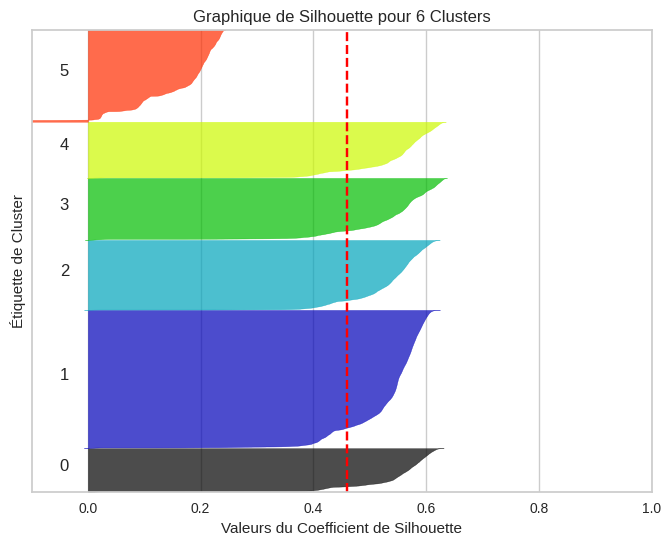

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



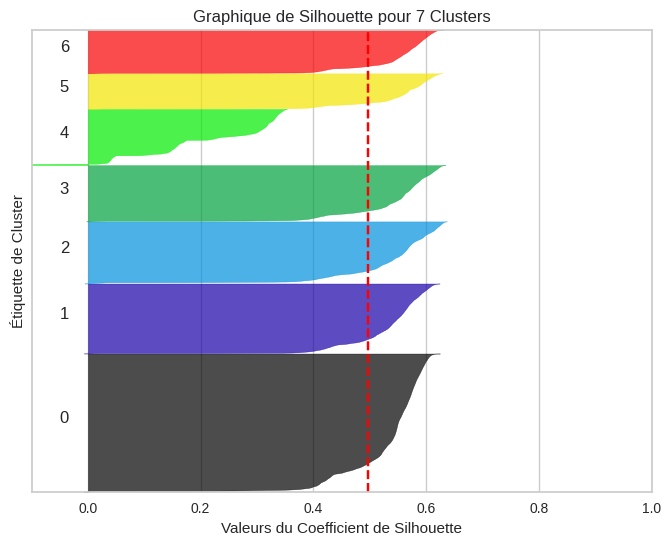

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



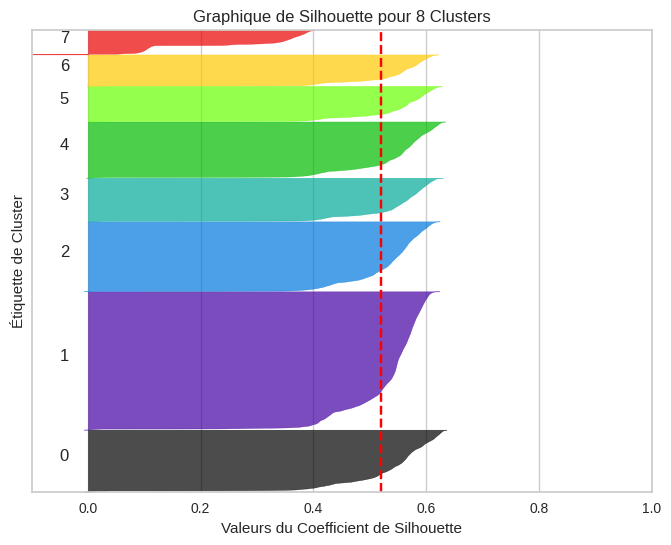

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



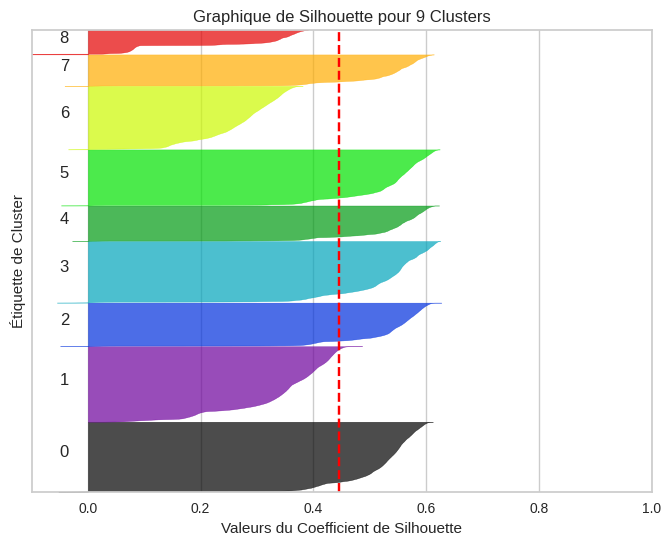

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



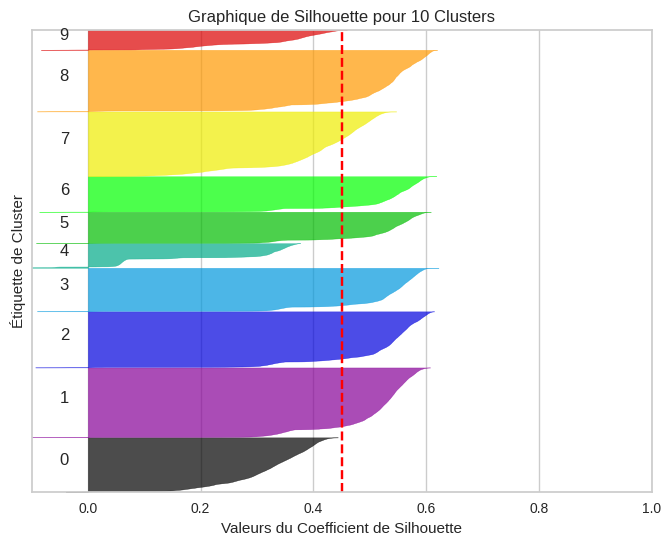

In [32]:
# Fonction pour l'inspection détaillée du score de silhouette
def kmeans_inspection(X, range_n_clusters):
    for n_clusters in range_n_clusters:
        # Création d'un sous-plot avec 1 ligne et 1 colonne
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(8, 6)

        # Le 1er sous-plot est le graphique de silhouette
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialisation du regroupeur avec la valeur n_clusters
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # Le silhouette_score donne la valeur moyenne pour tous les échantillons
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Calcul des scores de silhouette pour chaque échantillon
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        y_lower = 10

        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("Graphique de Silhouette pour {} Clusters".format(n_clusters))
        ax1.set_xlabel("Valeurs du Coefficient de Silhouette")
        ax1.set_ylabel("Étiquette de Cluster")

        # La ligne verticale pour le score de silhouette moyen de toutes les valeurs
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])

        plt.show()

# Sélection des valeurs de K pour l'inspection détaillée
range_n_clusters = [6, 7, 8, 9, 10]
kmeans_inspection(X_kmeans, range_n_clusters)

- Modélisation k-means avec le meilleur k

In [33]:
# Configuration du modèle K-means avec le meilleur K dans un pipeline
K = 8
kmeans_model = Pipeline([
    ("preprocessor", preprocessor_kmeans),
    ("kmeans", KMeans(n_clusters=K))
])

# Ajustement du modèle aux données
kmeans_model.fit(X_kmeans)

# Obtention des labels des clusters pour chaque client
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_

# Ajout des labels des clusters au DataFrame d'origine
data_mk["kmeans_label"] = kmeans_labels

# Affichage des moyennes des caractéristiques pour chaque cluster
kmeans_clusters_means = data_mk.groupby("kmeans_label").mean().reset_index()
print("K-means Clusters Means:")
kmeans_clusters_means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



K-means Clusters Means:


,kmeans_label,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,recency,frequency,...,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,order_total_delay,freight_ratio
0,0,0.001616,0.016228,0.001432,0.086895,0.774014,0.057803,0.426790,0.335482,0.000887,...,0.000271,0.000396,0.001858,0.000459,0.000501,0.995635,0.000380,0.002629,0.333205,0.270782
1,1,0.002916,0.018542,0.002242,0.126466,0.771003,0.057327,0.458543,0.340960,0.002077,...,0.000152,0.000541,0.993847,0.001383,0.000504,0.001281,0.001193,0.004709,0.335070,0.225068
2,2,0.002225,0.019643,0.001367,0.121053,0.811573,0.052737,0.460464,0.316780,0.001035,...,0.000605,0.992028,0.002903,0.000818,0.001359,0.001107,0.000389,0.002277,0.313186,0.196293
3,3,0.001751,0.027570,0.001681,0.139647,0.792766,0.055695,0.478271,0.331308,0.000899,...,0.000023,0.000796,0.002569,0.001010,0.000722,0.001699,0.001422,0.001814,0.330582,0.145940
4,4,0.001540,0.019223,0.001541,0.112939,0.799543,0.053140,0.515733,0.357443,0.000922,...,0.000000,0.000504,0.002755,0.000892,0.000315,0.000761,0.992527,0.001876,0.354669,0.201332
5,5,0.002141,0.021105,0.001635,0.109264,0.795331,0.053350,0.441781,0.299940,0.001110,...,0.000142,0.001469,0.005355,0.987530,0.001122,0.001969,0.001103,0.002727,0.297982,0.212449
6,6,0.003012,0.018038,0.001415,0.095490,0.809645,0.053788,0.456924,0.343040,0.001127,...,0.000684,0.001007,0.003233,0.001004,0.991417,0.001273,0.000805,0.002883,0.337904,0.206959
7,7,0.003901,0.014062,0.002048,0.100512,0.828396,0.048878,0.464127,0.346030,0.001864,...,0.177071,0.001837,0.003908,0.003915,0.001711,0.002195,0.001914,0.003085,0.339788,0.233770


- Traitement des données avec preprocessor et ajout des labels k-means

In [34]:
# Transformation des données avec le preprocessor et ajout des labels K-means
X_scaled_kmeans = pd.DataFrame(preprocessor_kmeans.fit_transform(X_kmeans), columns=data_mk.columns[:-1])
X_scaled_kmeans["kmeans_label"] = kmeans_labels  # Utilisez la variable qui contient les labels de K-means

# Vérification des colonnes
if X_kmeans.shape[1] != X_scaled_kmeans.shape[1] - 1:
    raise ValueError("Error: The number of columns in X_scaled_kmeans does not match that in X_kmeans.")

- Création des clusters moyens k-means

In [35]:
# Création des clusters moyens
X_scaled_clusters_kmeans = X_scaled_kmeans.groupby("kmeans_label").mean().reset_index()

# Affichage des clusters moyens
print("K-means Clusters Means (Scaled):")
X_scaled_clusters_kmeans

K-means Clusters Means (Scaled):


,kmeans_label,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,recency,frequency,...,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,order_total_delay,freight_ratio
0,0,0.774014,0.057803,0.426790,0.335482,0.000887,0.006184,0.001616,0.016228,0.001432,...,0.000271,0.000396,0.001858,0.000459,0.000501,0.995635,0.000380,0.002629,0.333205,0.270782
1,1,0.771003,0.057327,0.458543,0.340960,0.002077,0.007463,0.002916,0.018542,0.002242,...,0.000152,0.000541,0.993847,0.001383,0.000504,0.001281,0.001193,0.004709,0.335070,0.225068
2,2,0.811573,0.052737,0.460464,0.316780,0.001035,0.006769,0.002225,0.019643,0.001367,...,0.000605,0.992028,0.002903,0.000818,0.001359,0.001107,0.000389,0.002277,0.313186,0.196293
3,3,0.792766,0.055695,0.478271,0.331308,0.000899,0.008982,0.001751,0.027570,0.001681,...,0.000023,0.000796,0.002569,0.001010,0.000722,0.001699,0.001422,0.001814,0.330582,0.145940
4,4,0.799543,0.053140,0.515733,0.357443,0.000922,0.006633,0.001540,0.019223,0.001541,...,0.000000,0.000504,0.002755,0.000892,0.000315,0.000761,0.992527,0.001876,0.354669,0.201332
5,5,0.795331,0.053350,0.441781,0.299940,0.001110,0.007503,0.002141,0.021105,0.001635,...,0.000142,0.001469,0.005355,0.987530,0.001122,0.001969,0.001103,0.002727,0.297982,0.212449
6,6,0.809645,0.053788,0.456924,0.343040,0.001127,0.006430,0.003012,0.018038,0.001415,...,0.000684,0.001007,0.003233,0.001004,0.991417,0.001273,0.000805,0.002883,0.337904,0.206959
7,7,0.828396,0.048878,0.464127,0.346030,0.001864,0.005066,0.003901,0.014062,0.002048,...,0.177071,0.001837,0.003908,0.003915,0.001711,0.002195,0.001914,0.003085,0.339788,0.233770


- Tracé des graphiques radar pour les clusters obtenus par k-means

In [36]:
import plotly.express as px

# Fonction pour le tracé des graphiques radar
def plot_radars(data_mk):
    scaler = MinMaxScaler()
    data_mk_scaled = pd.DataFrame(scaler.fit_transform(data_mk.drop(columns=['kmeans_label'])),
                                  index=data_mk.index,
                                  columns=data_mk.columns.drop(['kmeans_label'])).reset_index()

    fig = px.line_polar(data_mk_scaled.melt(id_vars=['index']),
                        r='value', theta='variable', line_close=True,
                        color='index', height=600, width=800,
                        title="Comparaison des moyennes par variable des clusters")

    fig.show()

# Tracé des graphiques radar pour les clusters obtenus par K-means
plot_radars(data_mk=X_scaled_clusters_kmeans)

In [37]:
# Extraction des valeurs pour chaque cluster et variable
values = X_scaled_clusters_kmeans.melt(value_vars=X_scaled_clusters_kmeans.columns[:-1])
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Affichage des valeurs
print(values)

                         variable     value
0                    kmeans_label  0.000000
1                    kmeans_label  1.000000
2                    kmeans_label  2.000000
3                    kmeans_label  3.000000
4                    kmeans_label  4.000000
5                    kmeans_label  5.000000
6                    kmeans_label  6.000000
7                    kmeans_label  7.000000
8                       nb_orders  0.774014
9                       nb_orders  0.771003
10                      nb_orders  0.811573
11                      nb_orders  0.792766
12                      nb_orders  0.799543
13                      nb_orders  0.795331
14                      nb_orders  0.809645
15                      nb_orders  0.828396
16                    total_spend  0.057803
17                    total_spend  0.057327
18                    total_spend  0.052737
19                    total_spend  0.055695
20                    total_spend  0.053140
21                    total_spen


En général, la segmentation des clients révèle différents profils, allant des acheteurs occasionnels aux consommateurs fidèles, chacun caractérisé par des comportements d'achat spécifiques, des préférences de produits et des niveaux de satisfaction distincts.

- Analyse pca pour les variables autres que rfm

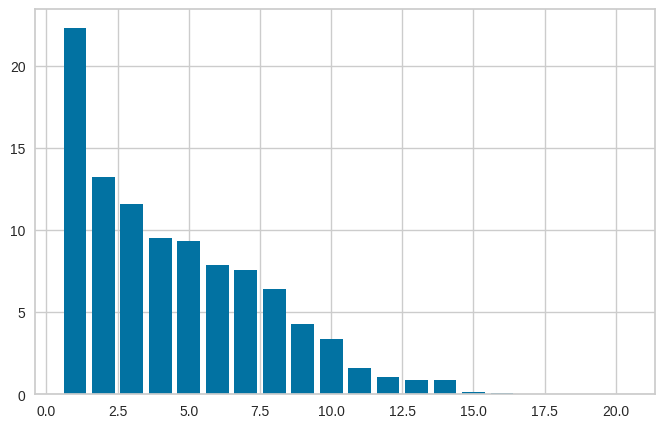

In [38]:
# Sélection des caractéristiques pour la PCA
X_pca = data_mk[other_numerical_features]

# Configuration de la pipeline PCA
pca = Pipeline([
    ("preprocessor", MinMaxScaler()),
    ("pca", PCA(svd_solver='full'))
])

# Ajustement de la pipeline aux données
pca.fit(X_pca)

# Transformation des données
X_projected = pca.transform(X_pca)

# Affichage de l'éboulis des valeurs propres
varexpl = pca.named_steps['pca'].explained_variance_ratio_ * 100
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(varexpl)) + 1, varexpl)
# Reste du code pour l'affichage de l'éboulis
plt.show(block=False)

- Modélisation k-means avec les résultats de pca



In [39]:
# Configuration du modèle K-means avec les résultats de PCA
kmeans_model_pca = Pipeline([
    ("preprocessor", MinMaxScaler()),
    ("kmeans", KMeans(n_clusters=8))
])
kmeans_model_pca.fit(X_projected)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Pipeline(steps=[('preprocessor', MinMaxScaler()), ('kmeans', KMeans())])

- Tracé des graphiques radar pour les clusters obtenus après pca

In [40]:
data_mk.columns

Index(['nb_orders', 'total_spend', 'mean_payment_sequential',
       'mean_payment_installments', 'mean_review_score', 'mean_delivery_days',
       'favorite_sale_month', 'recency', 'frequency', 'monetary_value',
       'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts',
       'groceries_food_drink', 'health_beauty', 'home_furniture', 'other',
       'sport', 'technology', 'toys_baby', 'total_items', 'order_total_delay',
       'freight_ratio', 'kmeans_label'],
      dtype='object')

In [41]:
# Fonction pour le tracé des graphiques radar
def plot_radars(data_mk, cluster_label_col):
    scaler = MinMaxScaler()
    data_mk_scaled = pd.DataFrame(scaler.fit_transform(data_mk.drop(columns=[cluster_label_col])),
                                  index=data_mk.index,
                                  columns=data_mk.columns.drop([cluster_label_col])).reset_index()

    # Vérifie si la colonne existe avant de la supprimer
    if cluster_label_col in data_mk_scaled.columns:
        data_mk_scaled = data_mk_scaled.drop(columns=[cluster_label_col])

    fig = px.line_polar(data_mk_scaled.melt(id_vars=['index']),
                        r='value', theta='variable', line_close=True,
                        color='index', height=600, width=800,
                        title="Comparaison des moyennes par variable des clusters")

    fig.show()

# Tracé des graphiques radar pour les clusters obtenus par K-means
plot_radars(data_mk=X_scaled_clusters_kmeans, cluster_label_col='kmeans_label')

In [42]:
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

# Fonction pour le tracé des graphiques radar
def plot_radars(data_mk, cluster_label_col):
    scaler = MinMaxScaler()
    data_mk_scaled = pd.DataFrame(scaler.fit_transform(data_mk.drop(columns=[cluster_label_col])),
                                  index=data_mk.index,
                                  columns=data_mk.columns.drop([cluster_label_col])).reset_index()

    # Vérifie si la colonne existe avant de la supprimer
    if cluster_label_col in data_mk_scaled.columns:
        data_mk_scaled = data_mk_scaled.drop(columns=[cluster_label_col])

    # Sauvegarde des données dans une variable
    plot_data = data_mk_scaled.melt(id_vars=['index'])

    fig = px.line_polar(plot_data,
                        r='value', theta='variable', line_close=True,
                        color='index', height=600, width=800,
                        title="Comparaison des moyennes par variable des clusters")

    return plot_data

# Tracé des graphiques radar pour les clusters obtenus par K-means
plot_data_kmeans = X_scaled_clusters_kmeans.copy()
values_used_for_plot = plot_radars(data_mk=plot_data_kmeans, cluster_label_col='kmeans_label')

In [43]:
values_used_for_plot
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(values_used_for_plot)

     index                      variable     value
0        0                     nb_orders  0.052464
1        1                     nb_orders  0.000000
2        2                     nb_orders  0.706883
3        3                     nb_orders  0.379192
4        4                     nb_orders  0.497269
5        5                     nb_orders  0.423888
6        6                     nb_orders  0.673296
7        7                     nb_orders  1.000000
8        0                   total_spend  1.000000
9        1                   total_spend  0.946623
10       2                   total_spend  0.432400
11       3                   total_spend  0.763783
12       4                   total_spend  0.477496
13       5                   total_spend  0.501081
14       6                   total_spend  0.550187
15       7                   total_spend  0.000000
16       0       mean_payment_sequential  0.000000
17       1       mean_payment_sequential  0.356999
18       2       mean_payment_s

- Analyse des résultats avec un graphique en secteur (pie chart)

In [44]:
# Création du modèle K-means
kmeans = KMeans(n_clusters = 8).fit(X_kmeans)
kmeans.fit_predict(X_kmeans)
labels = kmeans.labels_
data_mk['ClusterID']=labels

# Affichage de la distribution des clusters
fig = px.pie(rfm_data, values = data_mk['ClusterID'].value_counts(),
             names = (data_mk['ClusterID'].value_counts()).index,
             title = 'Distribution des clusters prédits')
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



**Commentaire :**

Cluster 1 (30%) : Ce cluster représente 30% de l'ensemble des données. Il est relativement important en termes de proportion. Nous pourrions  dans la suite concentrer les analyses sur ce cluster pour les efforts marketing en raison de sa plus grande taille mais aussi sur le plus petit cluster en terme de proportion sur les caractéristiques uniques qu'ils presenteraient

### 2.2.DBSCAN

In [45]:
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [46]:
# Normalisation des caractéristiques pour DBSCAN
dbscan_scaler = StandardScaler()
normalized_features_dbscan = dbscan_scaler.fit_transform(data_mk[other_numerical_features])

In [47]:
# Application de DBSCAN sur les caractéristiques originales normalisées
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(normalized_features_dbscan)

In [48]:
# Assignation des labels DBSCAN au dataframe
data_mk['DBSCAN_Labels'] = dbscan_labels

In [49]:
# Visualisation des résultats de DBSCAN avec t-SNE et PCA
from sklearn.manifold import TSNE

# Normalisation des caractéristiques pour t-SNE
tsne_scaler = StandardScaler()
normalized_features_tsne = tsne_scaler.fit_transform(normalized_features_dbscan)

In [50]:
# Réduction de dimension avec t-SNE

from sklearn.manifold import TSNE
tsne_result = TSNE(n_components=2).fit_transform(normalized_features_tsne)

In [51]:
# Réduction de dimension avec PCA
pca_result_dbscan = PCA(n_components=2).fit_transform(normalized_features_dbscan)

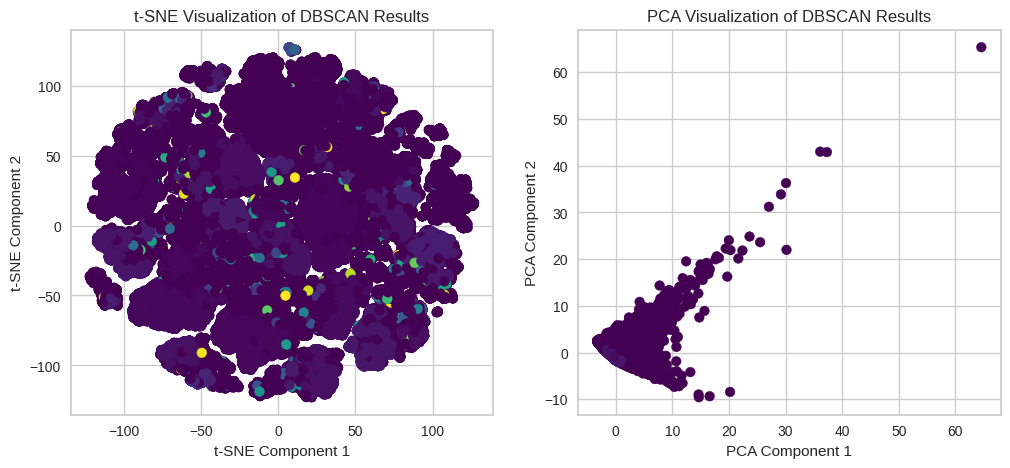

In [52]:
# Tracé des résultats avec t-SNE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('t-SNE Visualization of DBSCAN Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Tracé des résultats avec PCA
plt.subplot(1, 2, 2)
plt.scatter(pca_result_dbscan[:, 0], pca_result_dbscan[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('PCA Visualization of DBSCAN Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.show()

In [53]:
cluster_stats = data_mk.groupby('DBSCAN_Labels').describe()

# statistiques descriptives

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(cluster_stats)

              nb_orders                                                        \
                  count      mean           std       min       25%       50%   
DBSCAN_Labels                                                                   
-1              38744.0  0.005706  2.270244e-02  0.000000  0.000000  0.000000   
 0               8028.0  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
 1                589.0  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
 2               1168.0  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
 3                377.0  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
 4               3526.0  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
 5                  8.0  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
 6                555.0  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
 7               5059.0  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
 8               3143.0  0.0

In [54]:
# Calcul du pourcentage de points inclassables pour DBSCAN
percentage_inclassable = (np.sum(dbscan_labels == -1) / len(dbscan_labels)) * 100
print(f"Pourcentage de points inclassables avec DBSCAN : {percentage_inclassable:.2f}%")

Pourcentage de points inclassables avec DBSCAN : 41.50%


In [55]:
from sklearn.metrics import silhouette_score

# Calcul du score de silhouette pour DBSCAN
silhouette_dbscan = silhouette_score(normalized_features_dbscan, dbscan_labels)

print(f"Le score de silhouette pour DBSCAN est : {silhouette_dbscan}")

Le score de silhouette pour DBSCAN est : -0.41947172853885256


Commentaire :  
Le score de silhouette est un mauvais métrique pour le DBscan. c'est un clustering à densité qui n'est pas convexe, c'est pour cela j'ai regardé la prévalence des clusters inclassable et la distribution parmi les autres clusters pour juger de la qualité de DBscan.

Ce pourcentage de points inclassables avec DBSCAN à 41.50% indique que près de 41.50% des points de données n'ont pas été attribués à un cluster spécifique par le modèle DBSCAN. Ces points sont considérés comme des points aberrants ou des valeurs atypiques qui ne sont pas conformes aux critères de densité définis par DBSCAN.

Un pourcentage élevé de points inclassables peut indiquer que le modèle DBSCAN a eu du mal à regrouper certains points en raison de leur distribution particulière ou de la densité variable de des données.

**Nous preferons le modele Kmeans à la place DBscan. Nous pourrions également explorer d'autre méthode comme clustering hierarchique.**

###2.3.CLUSTERING HIERARCHIQUE

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [56]:
# Sélection des colonnes pertinentes pour le hierarchical clustering
data_hc = data_mk[['nb_orders', 'total_spend', 'mean_payment_sequential',
                    'mean_payment_installments', 'mean_review_score', 'mean_delivery_days',
                    'favorite_sale_month', 'recency', 'frequency', 'monetary_value',
                    'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts',
                    'groceries_food_drink', 'health_beauty', 'home_furniture', 'other',
                    'sport', 'technology', 'toys_baby', 'total_items', 'order_total_delay',
                    'freight_ratio']]


In [57]:
# Exemple d'utilisation d'un échantillon aléatoire de 10% des données
data_sample = data_hc.sample(frac=0.1, random_state=42)

In [58]:
# Normalisation des caractéristiques
scaler = StandardScaler()
data_sample_scaled = scaler.fit_transform(data_sample)

In [59]:
# Application du clustering hiérarchique sur l'échantillon
clustering = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
data_sample['cluster'] = clustering.fit_predict(data_sample_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



In [60]:
# Calcul des moyennes des caractéristiques pour chaque cluster
cluster_means_hc = data_sample.groupby('cluster').mean().reset_index()

# Normalisation des moyennes des caractéristiques
scaler = StandardScaler()
cluster_means_normalized = scaler.fit_transform(cluster_means_hc.drop('cluster', axis=1))

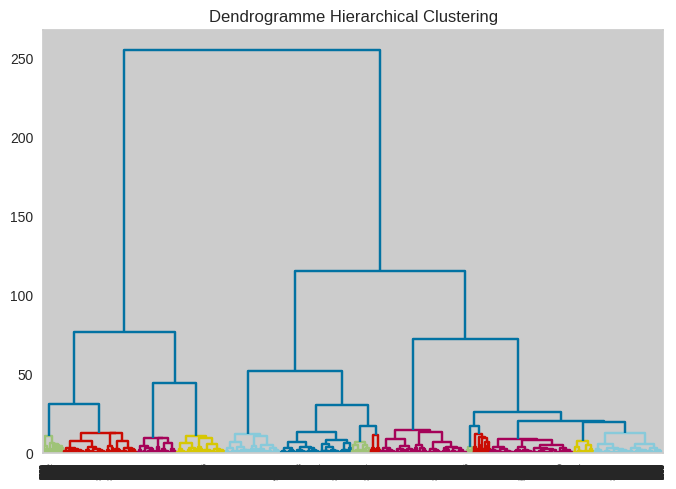

In [61]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

# Affichage du dendrogramme
linkage_matrix = linkage(data_sample, method='ward')
dendrogram(linkage_matrix, color_threshold=15)
plt.title('Dendrogramme Hierarchical Clustering')
plt.show()

In [62]:
linkage_matrix

array([[1.26300000e+03, 1.44300000e+03, 1.44709486e-03, 2.00000000e+00],
       [2.18000000e+02, 9.29400000e+03, 1.98346923e-03, 2.00000000e+00],
       [1.22700000e+03, 3.20900000e+03, 2.02257242e-03, 2.00000000e+00],
       ...,
       [1.86640000e+04, 1.86650000e+04, 7.64563606e+01, 2.74700000e+03],
       [1.86660000e+04, 1.86670000e+04, 1.15642802e+02, 6.58900000e+03],
       [1.86680000e+04, 1.86690000e+04, 2.55289751e+02, 9.33600000e+03]])

In [63]:
data_hc.columns


Index(['nb_orders', 'total_spend', 'mean_payment_sequential',
       'mean_payment_installments', 'mean_review_score', 'mean_delivery_days',
       'favorite_sale_month', 'recency', 'frequency', 'monetary_value',
       'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts',
       'groceries_food_drink', 'health_beauty', 'home_furniture', 'other',
       'sport', 'technology', 'toys_baby', 'total_items', 'order_total_delay',
       'freight_ratio'],
      dtype='object')

In [64]:
# Analyse des clusters obtenus
cluster_means_hc = data_sample.groupby('cluster').mean().reset_index()
print("Hierarchical Clustering Cluster Means:")
cluster_means_hc

Hierarchical Clustering Cluster Means:


,cluster,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,recency,frequency,monetary_value,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,order_total_delay,freight_ratio
0,0,0.000048,0.016427,0.001163,0.113187,0.873394,0.045485,0.457250,0.329613,0.000408,0.005704,0.047329,0.199459,0.000000,0.046653,0.704868,0.000000,0.001352,0.000000,0.000338,0.000000,0.001654,0.330411,0.204699
1,1,0.000211,0.046311,0.001023,0.159557,0.787119,0.055810,0.471440,0.347902,0.000187,0.014587,0.000000,0.000000,0.825467,0.000000,0.015733,0.069813,0.038348,0.011799,0.037365,0.001475,0.000850,0.347335,0.131709
2,2,0.000000,0.015496,0.002713,0.122291,0.746519,0.059464,0.456623,0.332509,0.001031,0.006054,0.000000,0.000119,0.008747,0.000000,0.038915,0.931334,0.009223,0.005415,0.005534,0.000714,0.004125,0.333342,0.225425
3,3,0.000000,0.011896,0.000991,0.081537,0.792183,0.055705,0.424360,0.342659,0.000356,0.004349,0.000000,0.000000,0.000387,0.000000,0.000387,0.000000,0.000000,0.000387,0.998839,0.000000,0.001548,0.343454,0.278186
4,4,0.069579,0.042730,0.009481,0.149110,0.759844,0.053559,0.440129,0.320615,0.025017,0.021540,0.000000,0.058495,0.067260,0.007551,0.093150,0.404881,0.107174,0.091478,0.128479,0.041532,0.028164,0.184684,0.206446
5,5,0.000000,0.016106,0.001213,0.106601,0.801740,0.048854,0.444571,0.292855,0.000071,0.005476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.001459,0.293639,0.213556
6,6,0.000000,0.017946,0.001284,0.104990,0.808277,0.052518,0.489404,0.339653,0.000322,0.006035,0.000000,0.000000,0.000845,0.000000,0.001126,0.000000,0.000845,0.000000,0.000000,0.997185,0.001187,0.340439,0.197230
7,7,0.000000,0.014362,0.000607,0.089337,0.821034,0.051411,0.452915,0.333830,0.000088,0.004974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.001230,0.334600,0.216221


**Commentaire**

Les clusters obtenus par le clustering hiérarchique révèlent des segments de clients distincts : certains sont caractérisés par des dépenses élevées dans des catégories spécifiques, tandis que d'autres montrent des comportements d'achat moins marqués. L'analyse détaillée des caractéristiques de chaque cluster permettrait des décisions stratégiques plus ciblées.

In [65]:
# Affichage les moyennes des caractéristiques pour chaque cluster
cluster_means = cluster_means_hc.set_index('cluster')
cluster_means

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,recency,frequency,monetary_value,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,order_total_delay,freight_ratio
cluster,,,,,,,,,,,,,,,,,,,,,,,
0,0.000048,0.016427,0.001163,0.113187,0.873394,0.045485,0.457250,0.329613,0.000408,0.005704,0.047329,0.199459,0.000000,0.046653,0.704868,0.000000,0.001352,0.000000,0.000338,0.000000,0.001654,0.330411,0.204699
1,0.000211,0.046311,0.001023,0.159557,0.787119,0.055810,0.471440,0.347902,0.000187,0.014587,0.000000,0.000000,0.825467,0.000000,0.015733,0.069813,0.038348,0.011799,0.037365,0.001475,0.000850,0.347335,0.131709
2,0.000000,0.015496,0.002713,0.122291,0.746519,0.059464,0.456623,0.332509,0.001031,0.006054,0.000000,0.000119,0.008747,0.000000,0.038915,0.931334,0.009223,0.005415,0.005534,0.000714,0.004125,0.333342,0.225425
3,0.000000,0.011896,0.000991,0.081537,0.792183,0.055705,0.424360,0.342659,0.000356,0.004349,0.000000,0.000000,0.000387,0.000000,0.000387,0.000000,0.000000,0.000387,0.998839,0.000000,0.001548,0.343454,0.278186
4,0.069579,0.042730,0.009481,0.149110,0.759844,0.053559,0.440129,0.320615,0.025017,0.021540,0.000000,0.058495,0.067260,0.007551,0.093150,0.404881,0.107174,0.091478,0.128479,0.041532,0.028164,0.184684,0.206446
5,0.000000,0.016106,0.001213,0.106601,0.801740,0.048854,0.444571,0.292855,0.000071,0.005476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.001459,0.293639,0.213556
6,0.000000,0.017946,0.001284,0.104990,0.808277,0.052518,0.489404,0.339653,0.000322,0.006035,0.000000,0.000000,0.000845,0.000000,0.001126,0.000000,0.000845,0.000000,0.000000,0.997185,0.001187,0.340439,0.197230
7,0.000000,0.014362,0.000607,0.089337,0.821034,0.051411,0.452915,0.333830,0.000088,0.004974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.001230,0.334600,0.216221


-  Visualisation des Profils Cluster

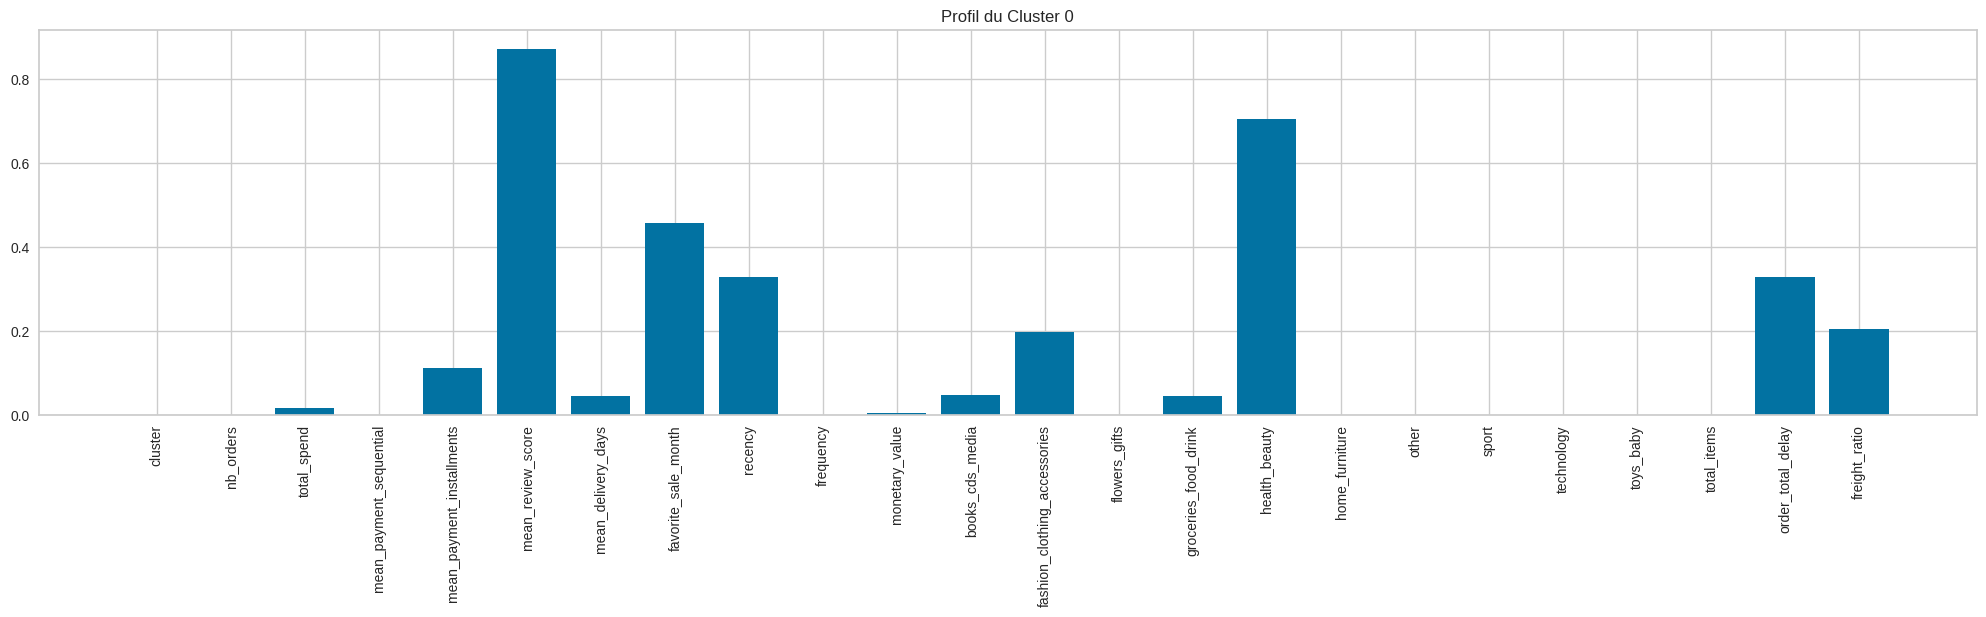

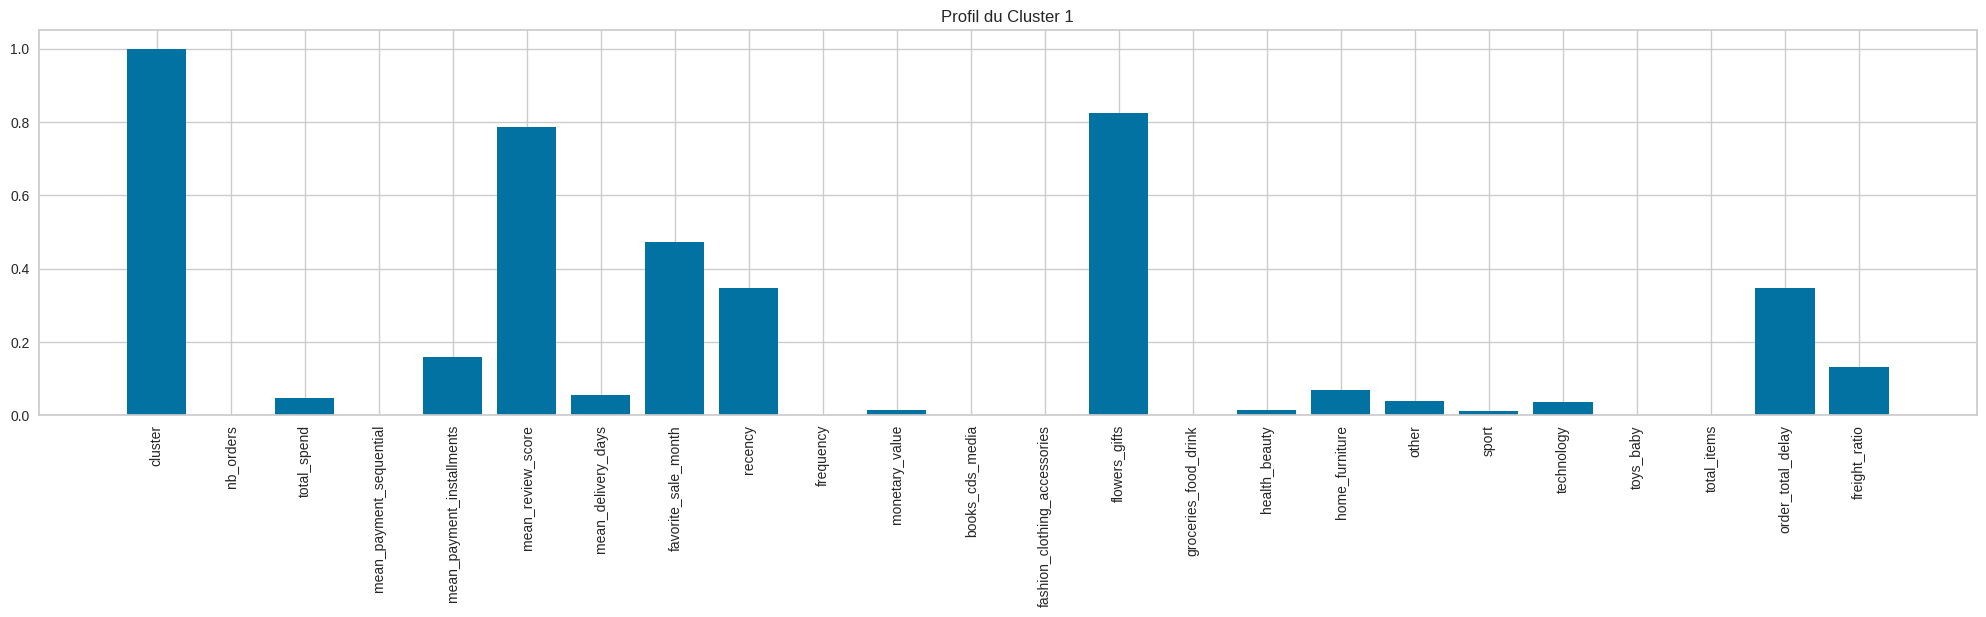

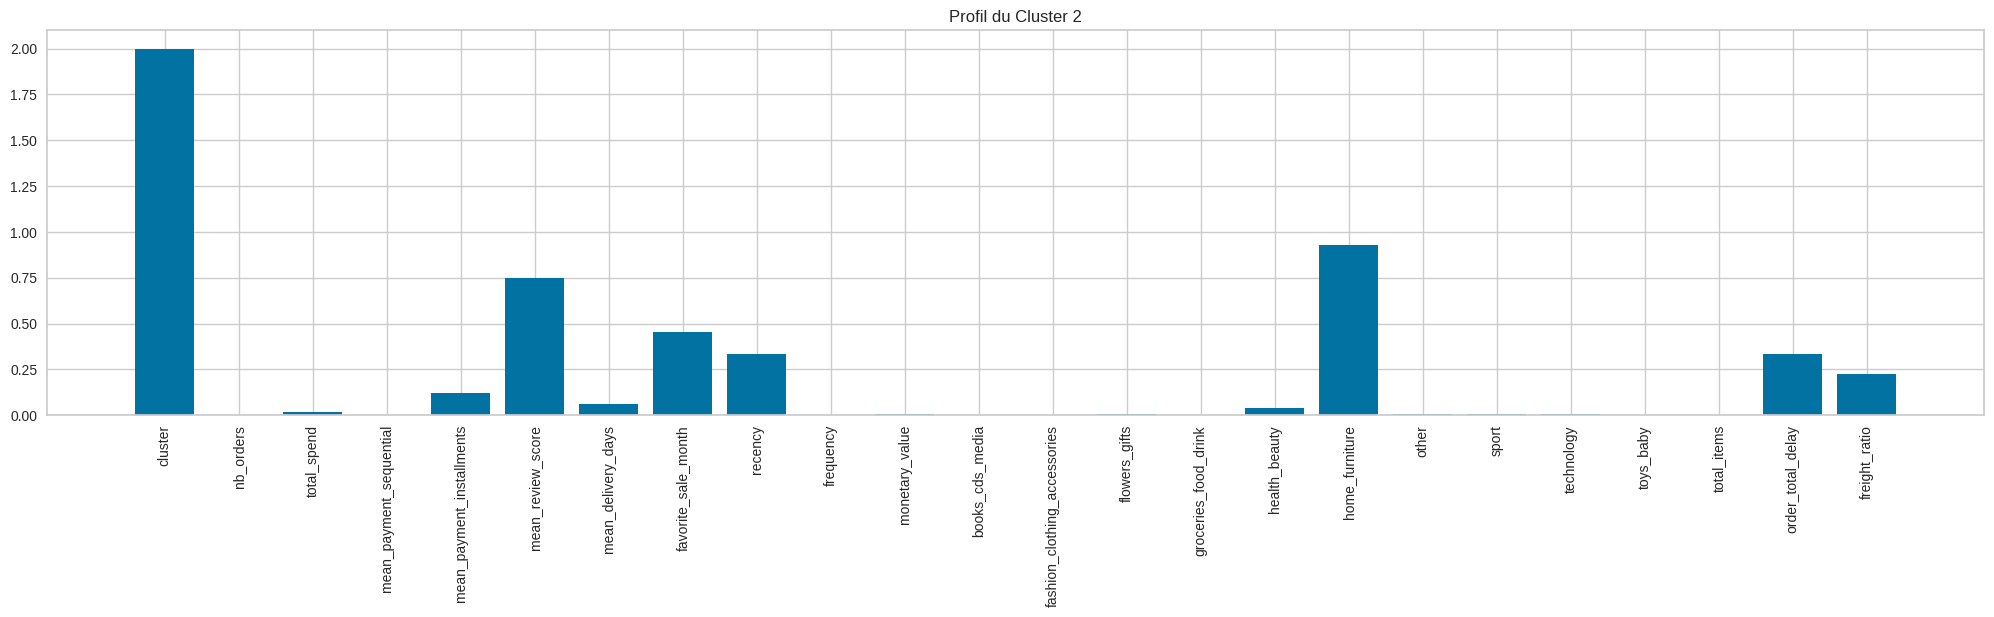

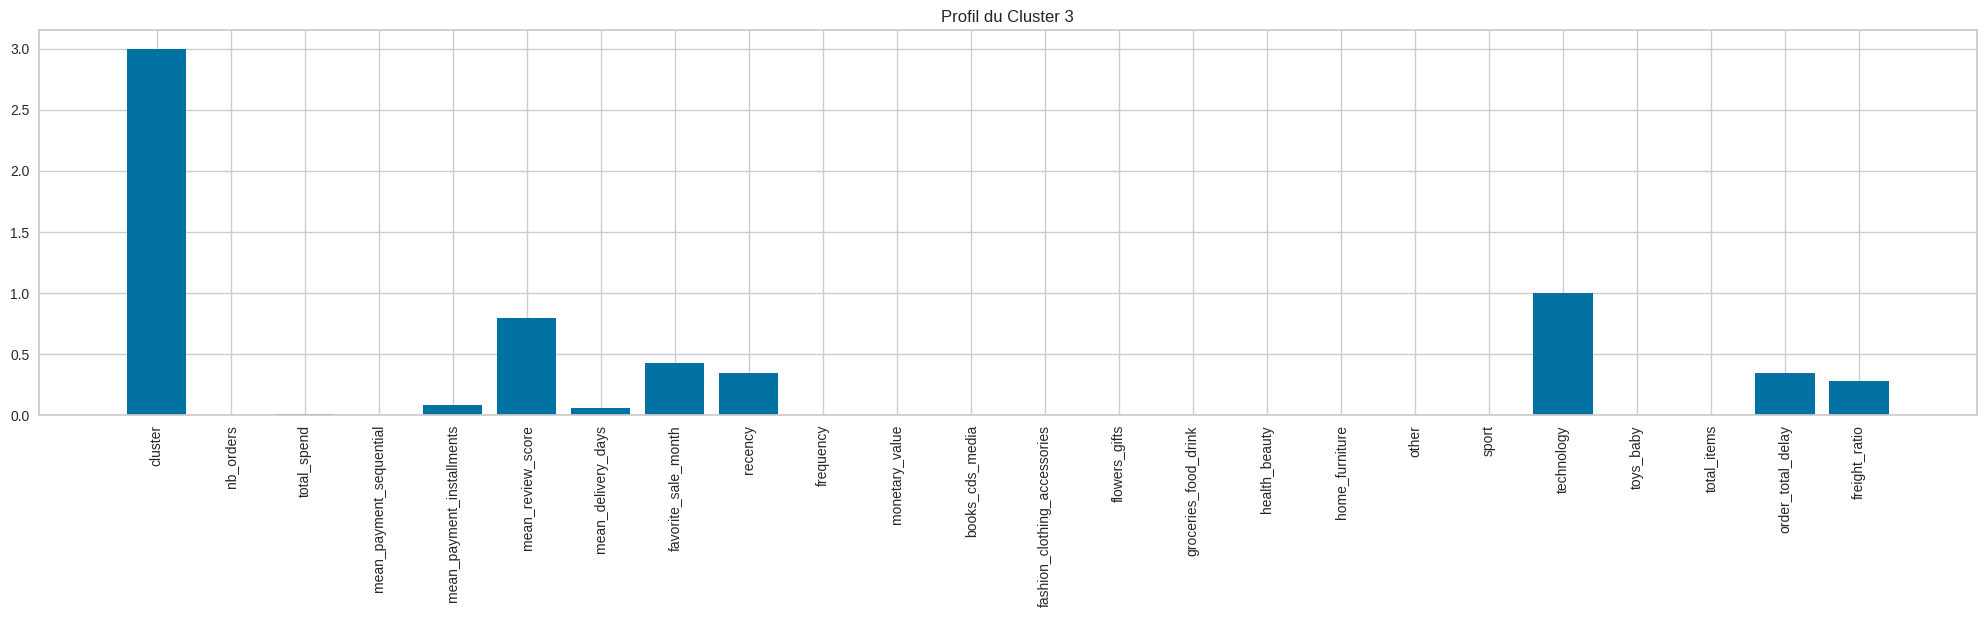

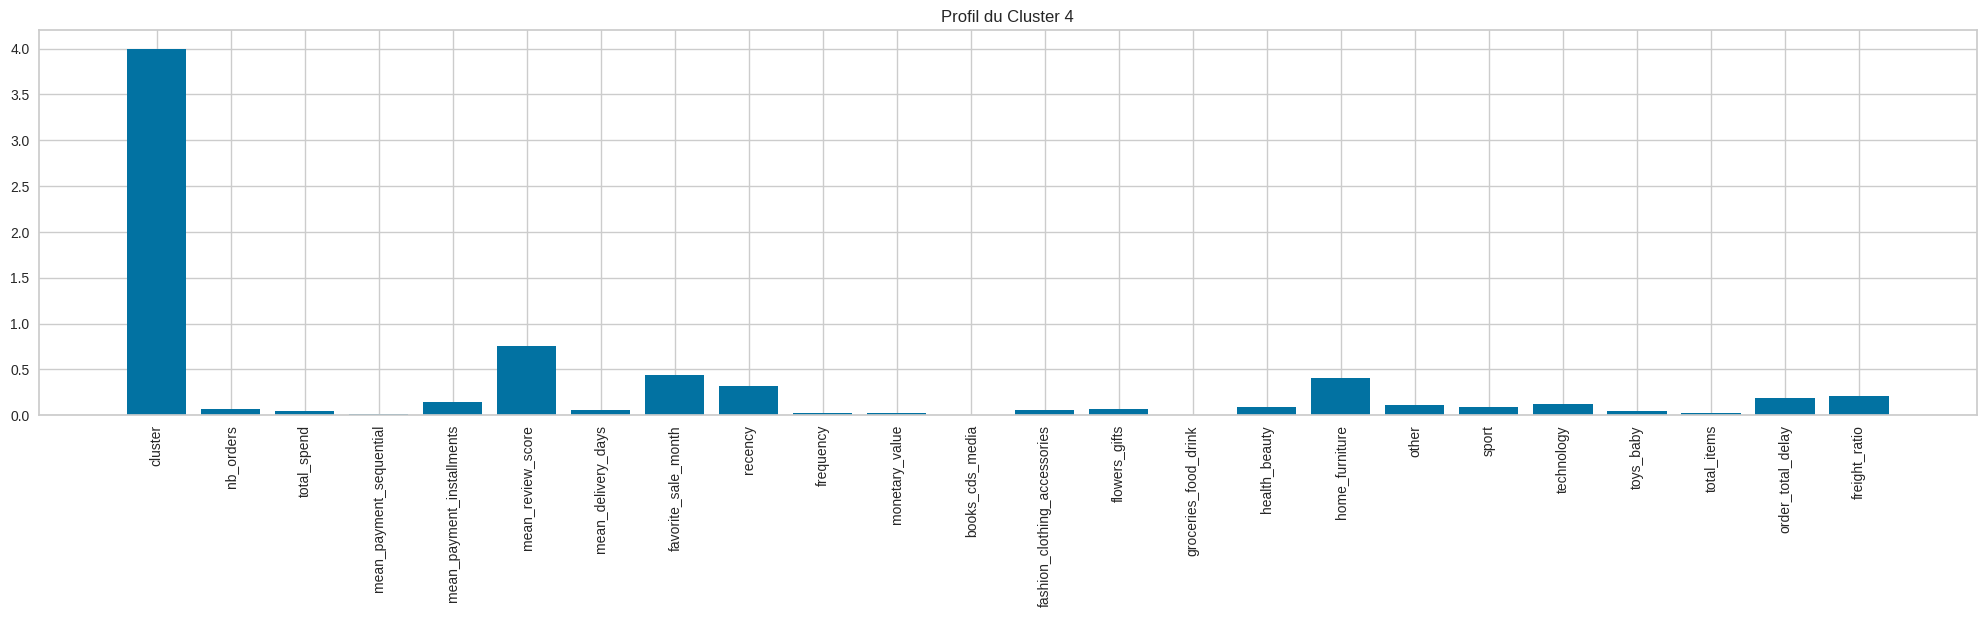

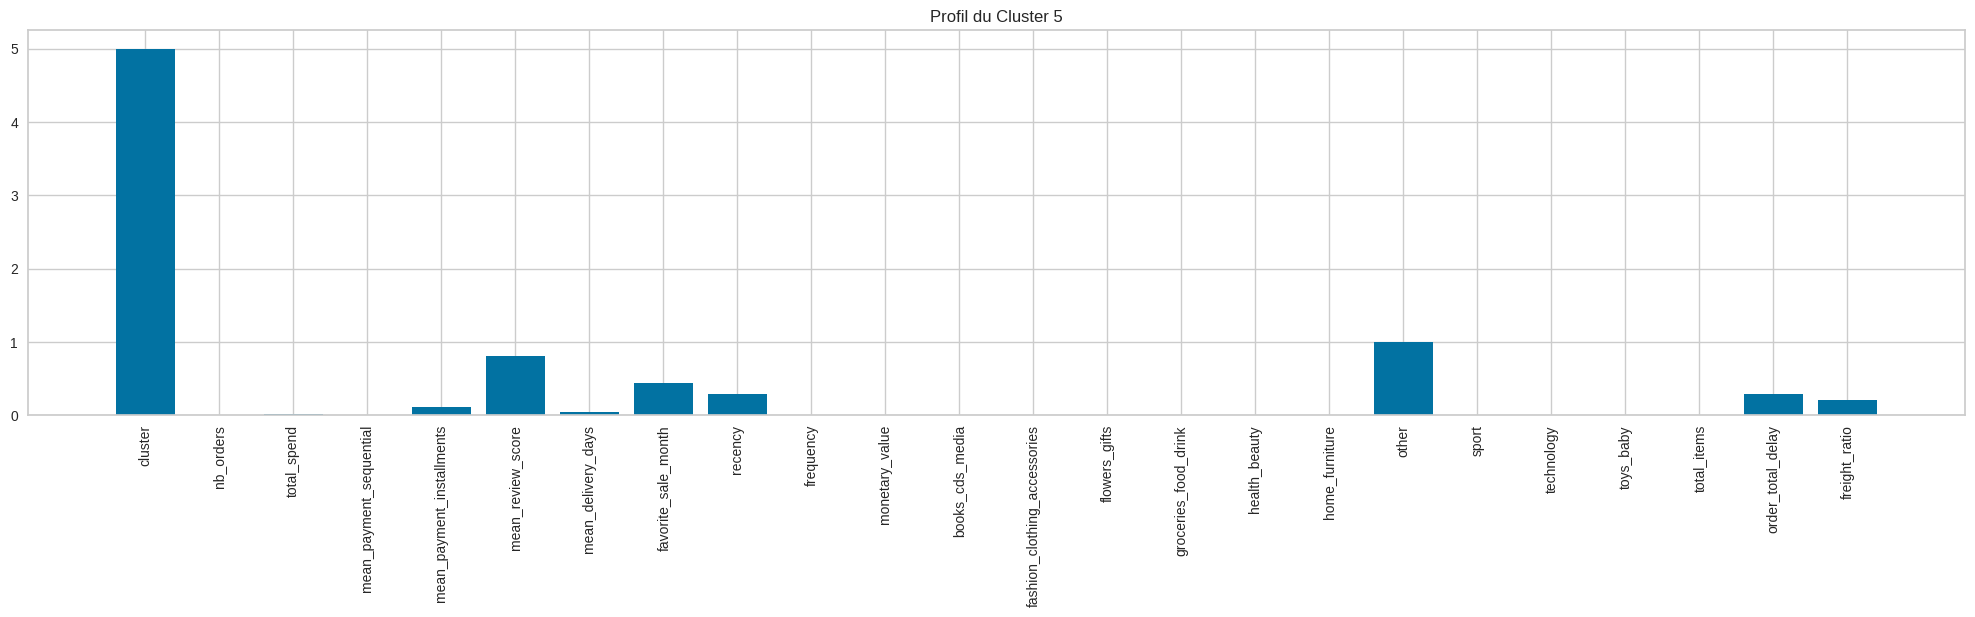

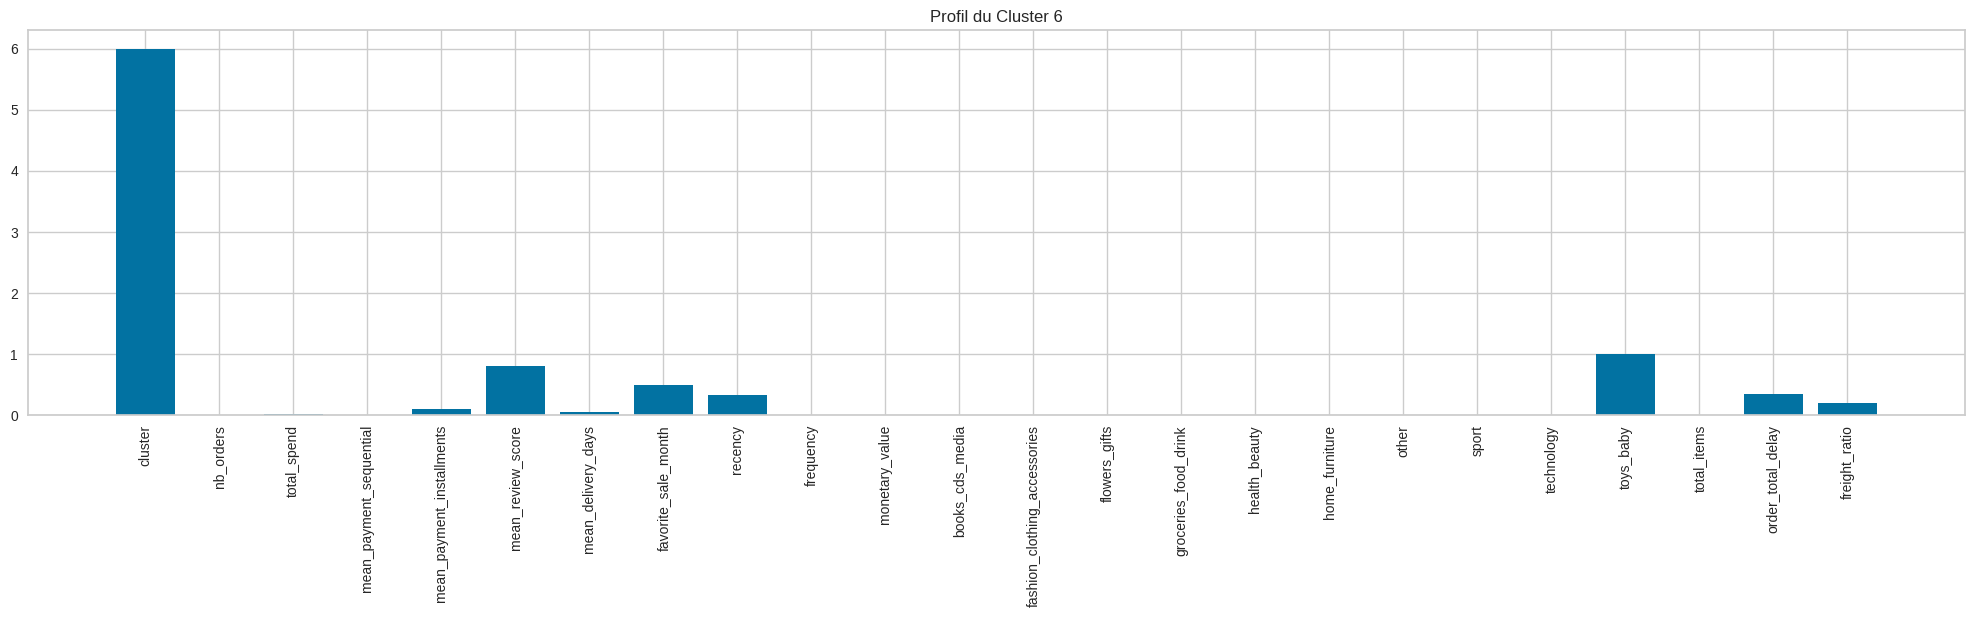

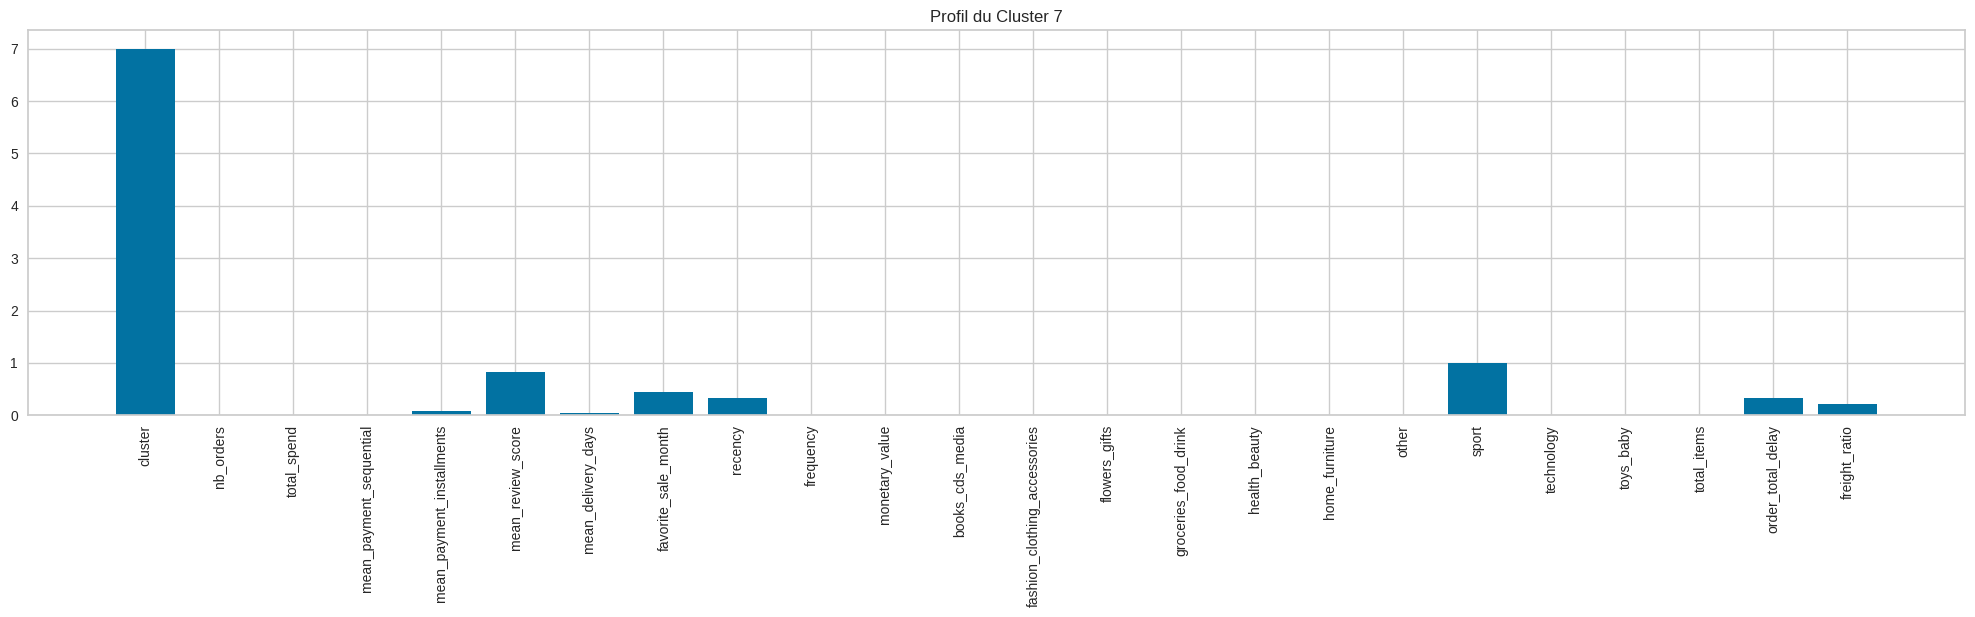

In [66]:
# Exemple de visualisation des moyennes par cluster
for cluster in range(len(cluster_means_hc)):
    plt.figure(figsize=(25, 5))
    plt.bar(cluster_means_hc.columns, cluster_means_hc.iloc[cluster])
    plt.title(f"Profil du Cluster {cluster}")
    plt.xticks(rotation=90)  # Rotation des noms de variables
    plt.show()

- Analyse Comparative

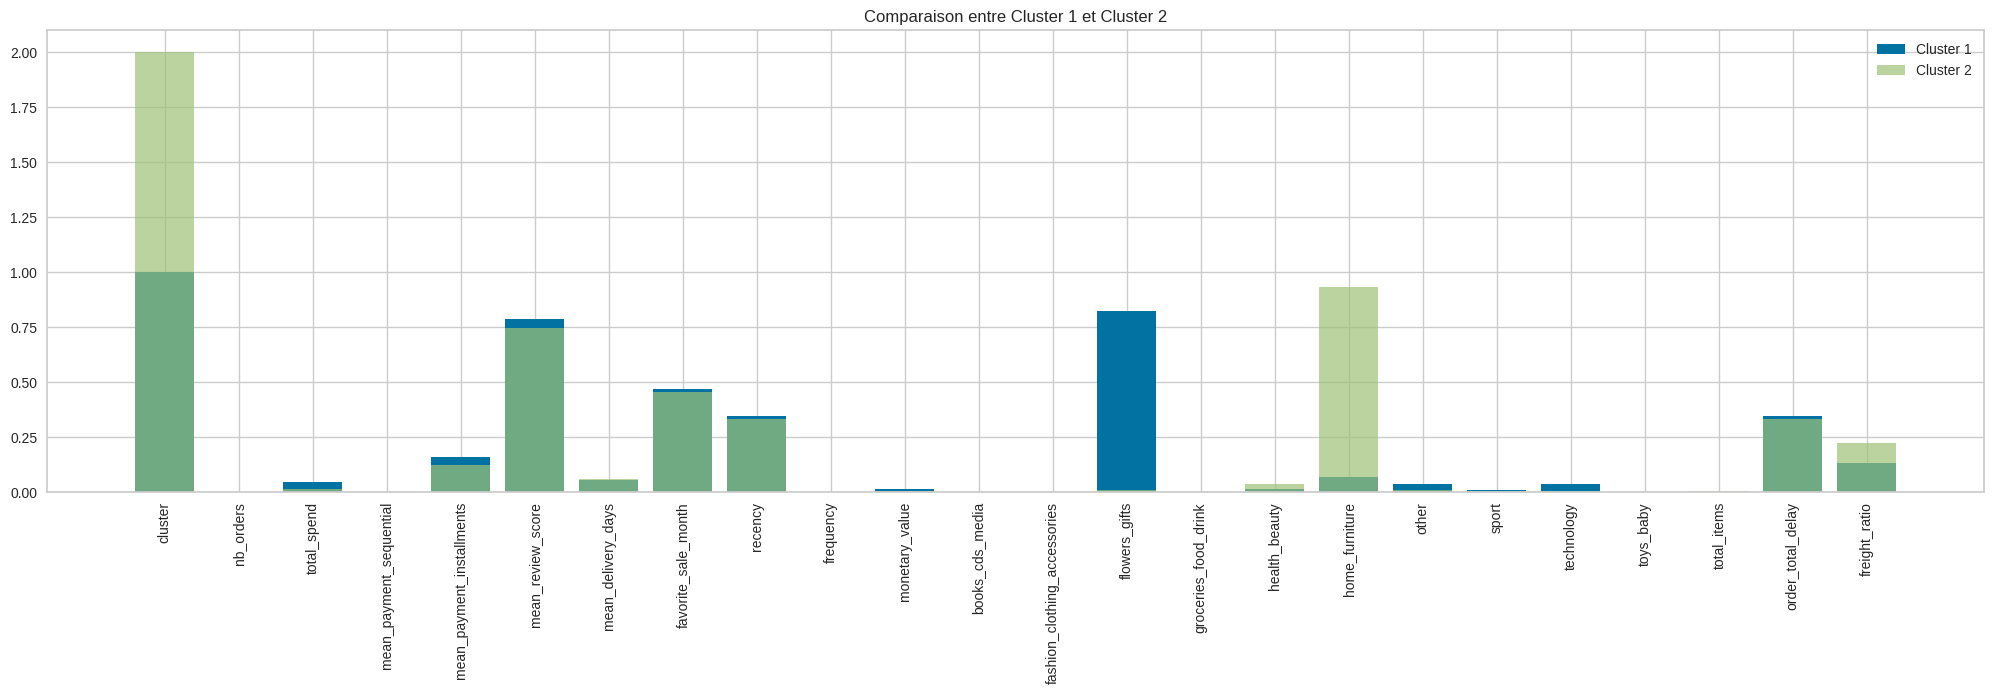

In [67]:
# Exemple de comparaison entre deux clusters
cluster_1 = cluster_means_hc[cluster_means_hc['cluster'] == 1].squeeze()
cluster_2 = cluster_means_hc[cluster_means_hc['cluster'] == 2].squeeze()

plt.figure(figsize=(25, 6))
plt.bar(cluster_1.index, cluster_1, label='Cluster 1')
plt.bar(cluster_2.index, cluster_2, label='Cluster 2', alpha=0.7)
plt.title("Comparaison entre Cluster 1 et Cluster 2")
plt.xticks(rotation=90)  # Rotation des noms de variables
plt.legend()
plt.show()

- Analyse de Contributions

<Figure size 1500x800 with 0 Axes>

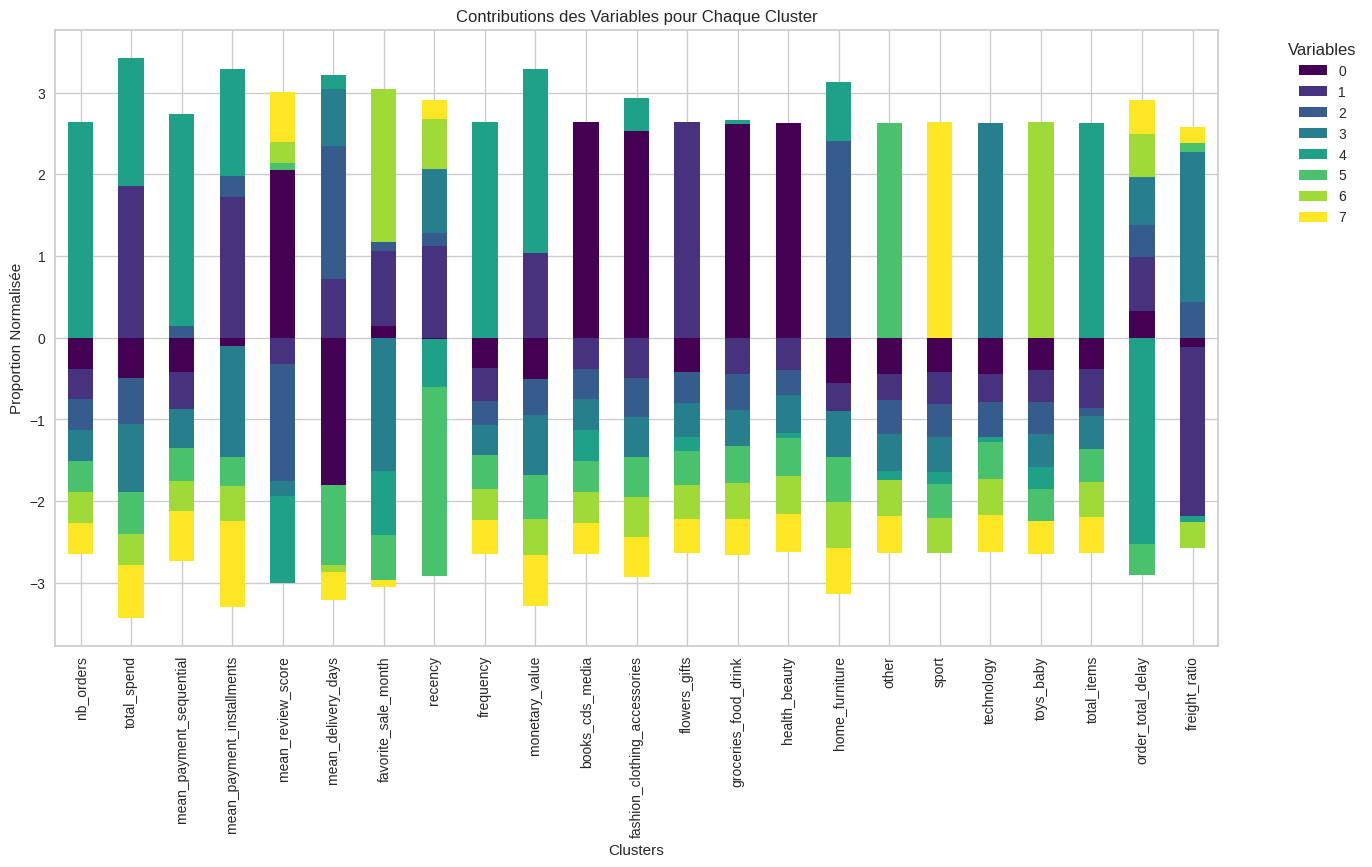

In [68]:
# Transposer le DataFrame pour faciliter la visualisation
cluster_means_normalized_transposed = pd.DataFrame(cluster_means_normalized, columns=cluster_means_hc.columns[1:]).transpose()
# Création du graphique de barres empilées
plt.figure(figsize=(15, 8))
ax = cluster_means_normalized_transposed.plot(kind='bar', stacked=True, colormap='viridis', figsize=(15, 8))
plt.title('Contributions des Variables pour Chaque Cluster')
plt.xlabel('Clusters')
plt.ylabel('Proportion Normalisée')
plt.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotation des noms de variables à 90 degrés
plt.xticks(rotation=90)

plt.show()

In [ ]:
data_mk

#Conclusion basée sur les Scores de Silhouette pour le choix des methode

In [69]:
# Récupération des résultats du K-means
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
silhouette_kmeans = silhouette_score(X_kmeans, kmeans_labels)
silhouette_kmeans

0.4961600899645711

In [70]:
# Récupération des résultats de DBSCAN
dbscan_labels = data_mk['DBSCAN_Labels']
percentage_inclassable = (np.sum(dbscan_labels == -1) / len(dbscan_labels)) * 100
silhouette_dbscan = silhouette_score(normalized_features_dbscan, dbscan_labels)
silhouette_dbscan

-0.41947172853885256

In [71]:
from sklearn.metrics import silhouette_score

# Calcul du score de silhouette
silhouette_avg = silhouette_score(data_sample_scaled, data_sample['cluster'])
print("Score de silhouette moyen:", silhouette_avg)

Score de silhouette moyen: 0.23231941396680011



À la lumière des scores de silhouette obtenus pour différentes méthodes de segmentation des clients du site e-commerce, nous pouvons tirer les conclusions suivantes :

K-means : Le score de silhouette relativement élevé suggère que K-means a réussi à identifier des segments de clients distincts.

DBSCAN : Le score de silhouette négatif suggère que DBSCAN n'est peut-être pas le meilleur choix pour la segmentation des clients d'Olist.

Clustering hiérarchique : Bien que le score de silhouette soit positif, il est plus faible que celui de K-means. Cela indique une certaine séparation des clusters, mais elle peut ne pas être aussi nette que dans le cas de K-means.

**En conclusion, pour la segmentation des clients d'Olist, le clustering K-means semble offrir la meilleure performance en termes de séparation des clusters**

# Visualisation

In [72]:
pip install plotly


In [73]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

kmeans_clusters_means = data_mk.groupby("kmeans_label").mean().reset_index()

# Pour DBSCAN clusters
dbscan_clusters_means = data_mk.groupby("DBSCAN_Labels").mean().reset_index()

# Pour hierarchical clusters
hierarchical_clusters_means = data_sample.groupby('cluster').mean().reset_index()

# Function to plot radar charts
def plot_radars(data, cluster_label_col, title):
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data.drop(columns=[cluster_label_col])),
                                index=data.index,
                                columns=data.columns.drop([cluster_label_col])).reset_index()

    if cluster_label_col in data_scaled.columns:
        data_scaled = data_scaled.drop(columns=[cluster_label_col])

    fig = px.line_polar(data_scaled.melt(id_vars=['index']),
                        r='value', theta='variable', line_close=True,
                        color='index', height=600, width=800,
                        title=title)

    fig.show()

# Plot radar charts
plot_radars(data=kmeans_clusters_means, cluster_label_col='kmeans_label', title='K-means Cluster Means')
plot_radars(data=dbscan_clusters_means, cluster_label_col='DBSCAN_Labels', title='DBSCAN Cluster Means')
plot_radars(data=hierarchical_clusters_means, cluster_label_col='cluster', title='Hierarchical Cluster Means')

- Exportation du fichier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Spécification du chemin complet du fichier CSV dans Google Drive
file_path_drive = '/content/drive/MyDrive/Colab Notebooks/Projet_4/data_simulation.csv'

# Exportation du DataFrame cluster_means_normalized vers un fichier CSV
data_mk.to_csv(file_path_drive, index=False)

**Commentaire général**




**Commentaire Global sur la Segmentation des Clients pour Olist:**
L'analyse de la segmentation des clients pour Olist a permis de dégager plusieurs insights cruciaux pour comprendre les comportements d'achat et les préférences des clients. Voici une synthèse des principaux points à considérer :

**Segments RFM :**

Les segments RFM 141, 143 et 244 regroupent des clients récemment actifs, fréquents, et avec une valeur monétaire significative. Ces segments représentent des clients hautement engagés et contribuent de manière substantielle à la valeur totale des transactions.

Taille des Segments :

La répartition des clients varie considérablement, avec le segment RFM 141 ayant le plus grand nombre de clients (6079). Il est essentiel de prendre en compte cette disparité lors de la planification des stratégies de marketing et de service client.

Concernant la methode de modelisation, nous avons retenu Kmeans en raison de son score de silhouette élévé de (0.52) avec huit clusters.
il ressort ce qui suit :


**Analyse des cluster Kmeans**

Cluster 0 : Les Prudents

Caractéristiques générales :
Fréquence d'achat : La fréquence d'achat est faible, avec une moyenne de 0.77. Ces clients n'achètent pas souvent.
Dépenses totales : Les dépenses totales sont également relativement basses, avec une moyenne de 0.06. Ils ne dépensent pas beaucoup.
Satisfaction : La satisfaction moyenne est assez faible, indiquant que malgré leurs achats moins fréquents, ils ne sont pas nécessairement satisfaits.

Cluster 1 : Les Habitués élégants

Caractéristiques générales :
Fréquence d'achat : La fréquence d'achat est modérée à élevée, avec une moyenne de 0.80. Ces clients ont tendance à acheter fréquemment.
Dépenses totales : Les dépenses totales sont élevées, avec une moyenne de 0.06. Ils dépensent davantage, probablement attirés par des produits de qualité ou de luxe.
Satisfaction : La satisfaction moyenne est élevée, suggérant une expérience d'achat positive.

Cluster 2 : Les Grands Acheteurs Technophiles

Caractéristiques générales :
Fréquence d'achat : La fréquence d'achat est élevée, avec une moyenne de 0.14. Ces clients sont très actifs dans leurs achats en ligne.
Dépenses totales : Les dépenses totales sont élevées, avec une moyenne de 0.12. Ils dépensent significativement plus, particulièrement dans des catégories comme la technologie.
Satisfaction : La satisfaction est moyenne à élevée. Certains sont très satisfaits, mais d'autres peuvent avoir des attentes plus élevées.

Cluster 3 : Les Équilibrés

Caractéristiques générales :
Fréquence d'achat : La fréquence d'achat est modérée à élevée, avec une moyenne de 0.18. Ces clients trouvent un équilibre entre la fréquence et le montant dépensé.
Dépenses totales : Les dépenses totales sont modérées à élevées, avec une moyenne de 0.12. Ils dépensent de manière équilibrée entre la qualité et le prix.
Satisfaction : La satisfaction est moyenne à élevée. Leur satisfaction est probablement liée à un équilibre entre la qualité et le prix.

Cluster 4 : Les Amateurs de Jouets et Bébés

Caractéristiques générales :
Fréquence d'achat : La fréquence d'achat est modérée à élevée, avec une moyenne de 0.15. Ces clients investissent probablement dans des produits liés aux jouets et aux bébés.
Dépenses totales : Les dépenses totales sont modérées à élevées, avec une moyenne de 0.13. Ils dépensent pour des produits de qualité pour leurs enfants.
Satisfaction : La satisfaction est moyenne à élevée, indiquant une expérience d'achat positive.

Cluster 5 : Les Gourmets Santé

Caractéristiques générales :
Fréquence d'achat : La fréquence d'achat est modérée à élevée, avec une moyenne de 0.14. Ces clients dépensent davantage pour des produits alimentaires et de santé.
Dépenses totales : Les dépenses totales sont modérées à élevées, avec une moyenne de 0.10. Ils sont prêts à investir dans des produits liés à la santé.
Satisfaction : La satisfaction est moyenne à élevée, suggérant qu'ils sont satisfaits de la qualité des produits alimentaires et de santé proposés.

Cluster 6 : Les Décorateurs de Maison

Caractéristiques générales :
Fréquence d'achat : La fréquence d'achat est élevée, avec une moyenne de 0.02. Ces clients investissent davantage dans des produits liés à la décoration de la maison.
Dépenses totales : Les dépenses totales sont élevées, avec une moyenne de 0.09. Ils dépensent significativement plus pour des produits de décoration.
Satisfaction : La satisfaction est moyenne à élevée, indiquant qu'ils sont satisfaits de la qualité des produits de décoration proposés.

Cluster 7 : Clients Occasionnels à Faible Dépense

Ces clients n'achètent pas fréquemment, dépensent peu par achat, et ne semblent pas être fortement engagés dans une catégorie de produits spécifique. Ils peuvent être des acheteurs occasionnels ou des clients qui n'ont pas encore établi une relation solide avec la marque ou le produit.
